In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline  # attention to imblearn Pipeline
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import RobustScaler, StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import time
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
)
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold,cross_validate
from imblearn.pipeline import Pipeline #PipeLine do Imlearn for Imbalanced Datasets!
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.under_sampling import RandomUnderSampler

In [2]:
def limits(columns):
    Q1 = columns.quantile(0.25) #quantile = quartil
    Q3 =  columns.quantile(0.75)
    amplitude = Q3- Q1
    inferior_limit = Q1 - 1.5 * amplitude
    superior_limit =  Q3 + 1.5 * amplitude
    return inferior_limit,superior_limit


def boxplot(coluna):
    fig,(ax1,ax2) = plt.subplots(1,2)
    fig.set_size_inches(15,5)
    sns.boxplot(x=coluna,ax=ax1)
    ax2.set_xlim(limits(coluna))
    sns.boxplot(x=coluna,ax=ax2)
    return



def delete_outliers(data,column_name):
    total_lines = data.shape[0]
    inferior_limits,superior_limits = limits(data[column_name])
    data = data.loc[(data[column_name]>= inferior_limits) & (data[column_name] <=superior_limits),:]
    removed_lines = total_lines -  data.shape[0]
    return data, removed_lines


def inspect_outliers(DataFrame, columns, whisker_width=1.5):
    Q1 = DataFrame[columns].quantile(0.25)
    Q3 = DataFrame[columns].quantile(0.75)
    iqr = Q3 - Q1
    inferior_limit = Q1 - whisker_width * iqr
    superior_limit = Q3 + whisker_width * iqr
    return DataFrame[
        (DataFrame[columns] < inferior_limit) | (DataFrame[columns] > superior_limit)
    ]

In [3]:
Data_scaled = pd.read_csv('Data_scaled.csv')

In [4]:
Data_scaled.shape[0]

284807

In [5]:
null_proportion = (Data_scaled.isnull().sum() / Data_scaled.shape[0]).sort_values(ascending=False)
top_20_nulls = null_proportion.head(20).apply(lambda x: f"{x*100:.2f}%")
print("Percentage of missing data in the top 20 columns:")
print(top_20_nulls)

Percentage of missing data in the top 20 columns:
V1               0.00%
V17              0.00%
scaled_amount    0.00%
Class            0.00%
V28              0.00%
V27              0.00%
V26              0.00%
V25              0.00%
V24              0.00%
V23              0.00%
V22              0.00%
V21              0.00%
V20              0.00%
V19              0.00%
V18              0.00%
V16              0.00%
V2               0.00%
V15              0.00%
V14              0.00%
V13              0.00%
dtype: object


In [6]:
features_v = [col for col in Data_scaled.columns if col.startswith('V')]
inspect_outliers(Data_scaled,'V1')

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
18,-5.401258,-5.450148,1.186305,1.736239,3.049106,-1.763406,-1.559738,0.160842,1.233090,0.345173,...,0.984460,2.458589,0.042119,-0.481631,-0.621272,0.392053,0.949594,0,0.346538,-0.994819
85,-4.575093,-4.429184,3.402585,0.903915,3.002224,-0.491078,-2.705393,0.666451,1.922216,-0.614312,...,0.853360,-0.971600,-0.114862,0.408300,-0.304576,0.547785,-0.456297,0,2.487389,-0.994337
140,-5.101877,1.897022,-3.458034,-1.277543,-5.517758,2.098366,3.329603,1.250966,0.271501,-0.305483,...,-0.678879,-0.555900,-0.761660,0.066611,0.767227,0.731634,-0.860310,0,12.542444,-0.993961
146,-5.285971,4.847323,-1.290368,-1.427842,-0.621533,-0.604691,0.437866,0.336384,3.558373,6.427802,...,-1.171187,0.150872,-0.493322,1.050554,0.194865,2.490503,1.575380,0,-0.182352,-0.993903
164,-6.093248,-12.114213,-5.694973,3.294389,-1.413792,4.776000,4.808426,-0.228197,-0.525896,-1.724899,...,-2.264037,-3.553381,1.215279,-0.406073,-0.653384,-0.711222,0.672900,0,53.182981,-0.993773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284631,-5.459612,4.844512,-5.127471,-0.772816,-2.098147,0.010068,-2.943210,4.723736,0.030501,-0.437485,...,-0.823664,0.766333,-0.498784,0.022025,0.271928,-0.032666,-0.021239,0,-0.170195,1.033036
284649,-11.946976,9.772660,-8.006237,-2.498596,-4.229520,-1.320039,-3.259766,5.059956,4.870093,8.570504,...,-1.529035,0.838689,-1.249172,1.714495,0.314623,2.112848,1.234408,0,-0.157339,1.033259
284772,-6.713826,2.369104,-3.534768,-0.368259,-1.721030,-1.322808,-0.190876,0.891149,2.068476,2.769699,...,0.994246,-0.002140,-0.072979,-0.167159,-0.387271,-2.616341,0.474584,0,-0.033676,1.034646
284795,-12.516732,10.187818,-8.476671,-2.510473,-4.586669,-1.394465,-3.632516,5.498583,4.893089,8.655320,...,-1.565026,0.890675,-1.253276,1.786717,0.320763,2.090712,1.232864,0,-0.169496,1.034857


C:\Users\vinic\AppData\Local\Temp\ipykernel_10780\56588873.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,(ax1,ax2) = plt.subplots(1,2)


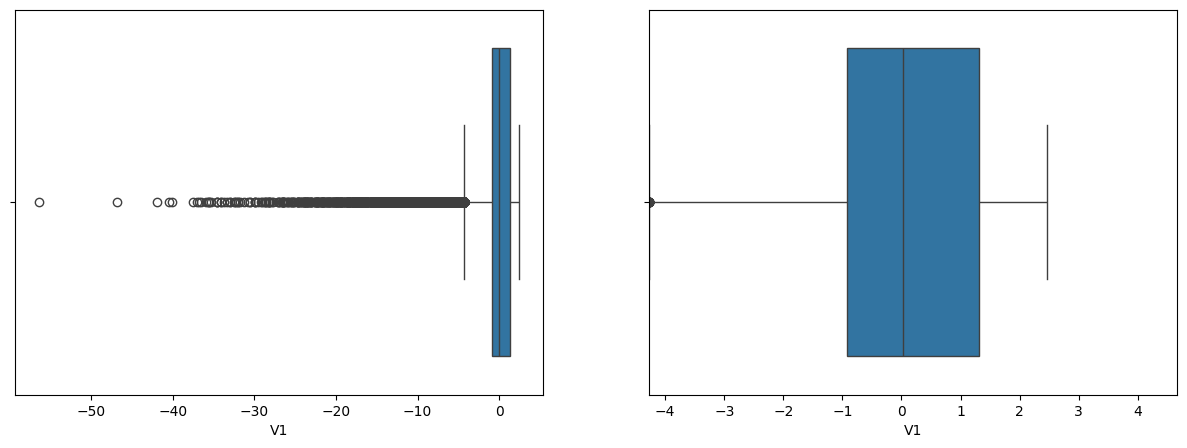

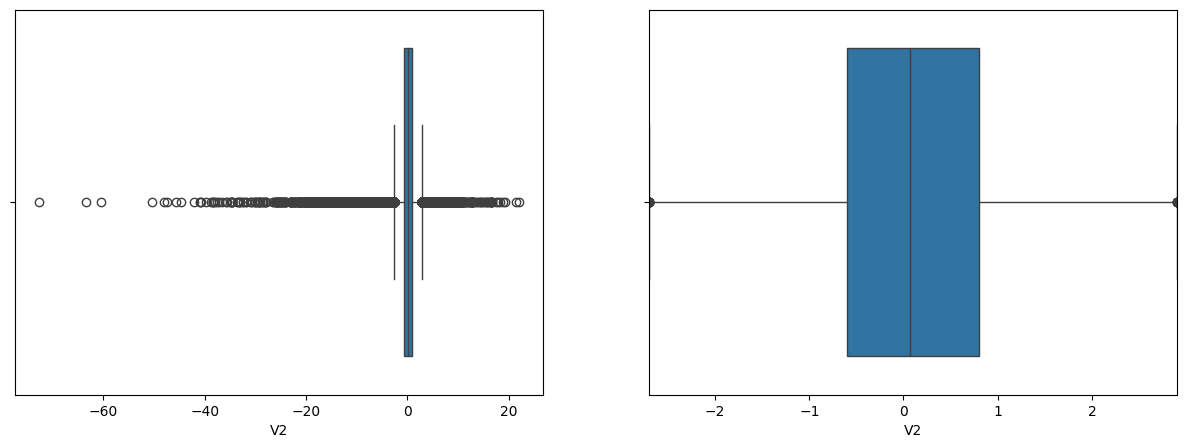

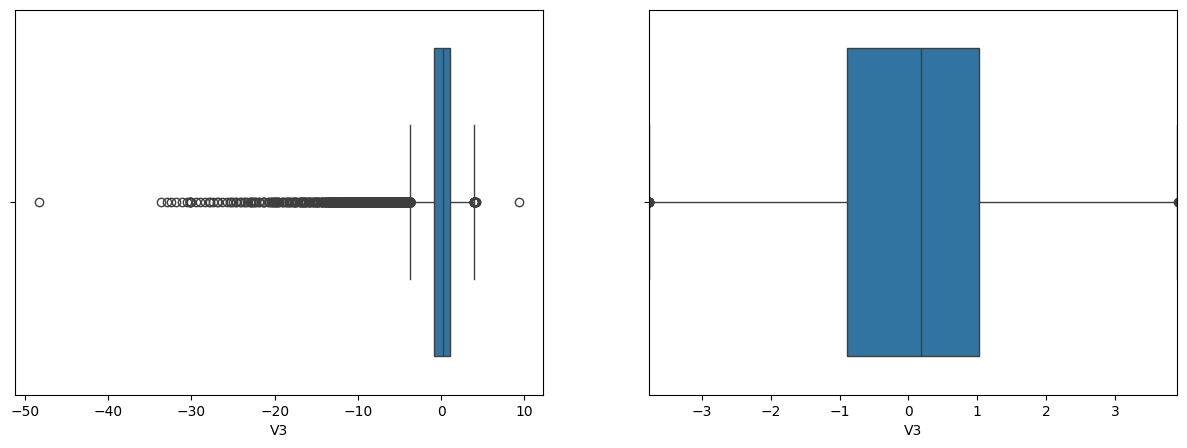

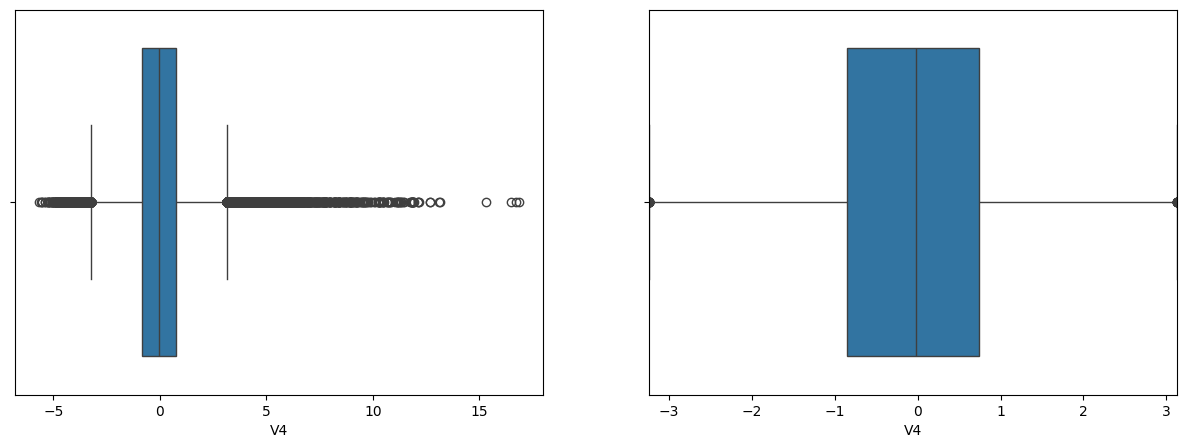

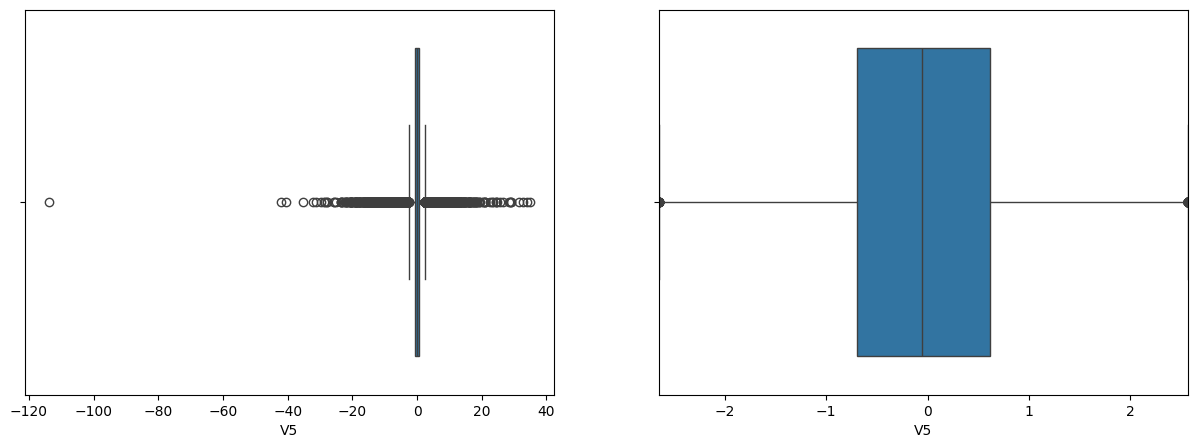

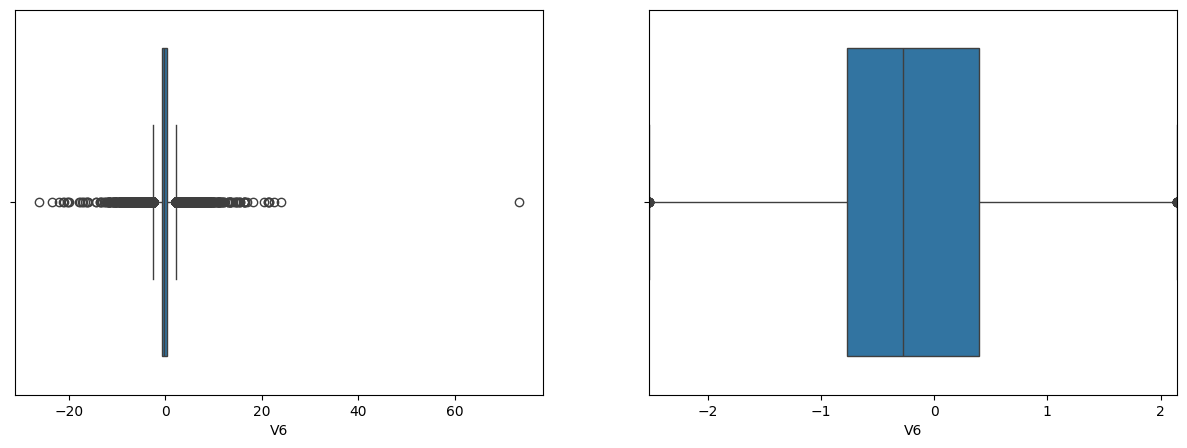

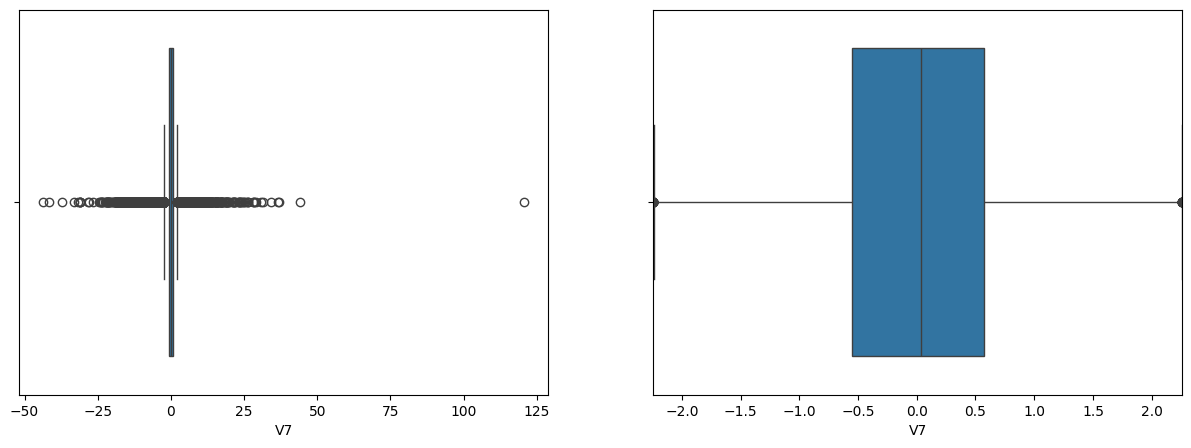

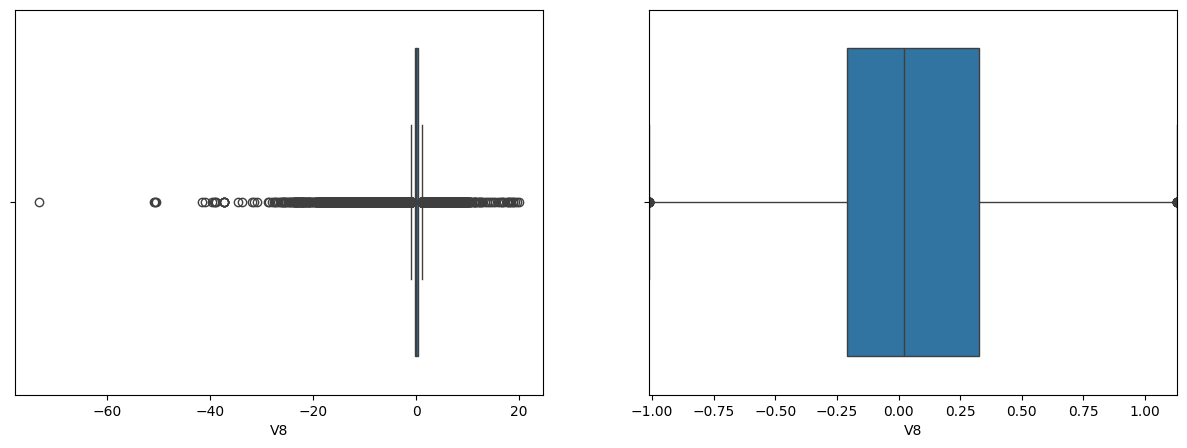

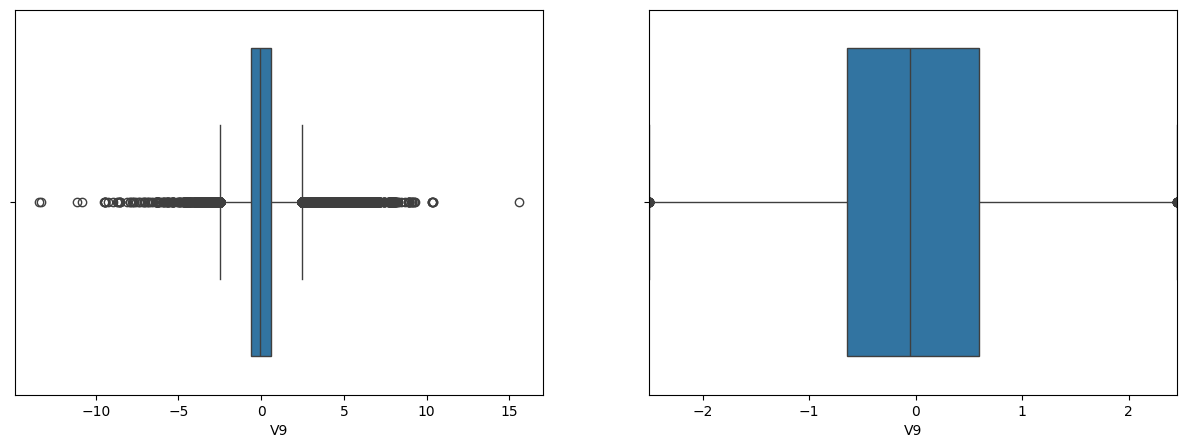

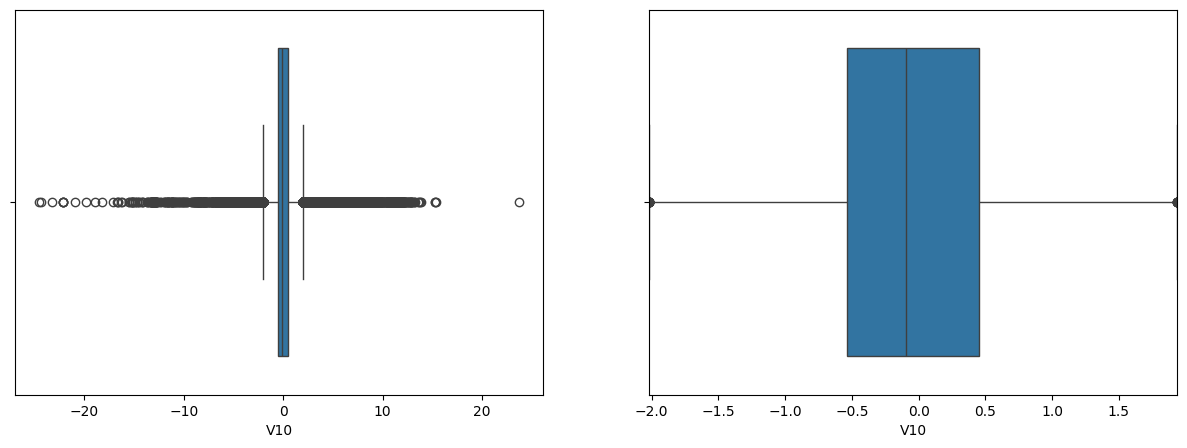

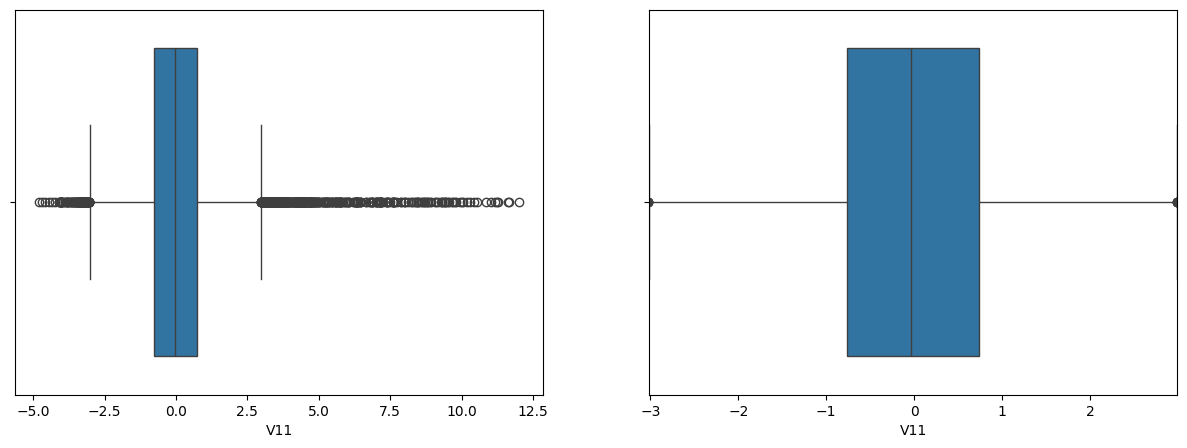

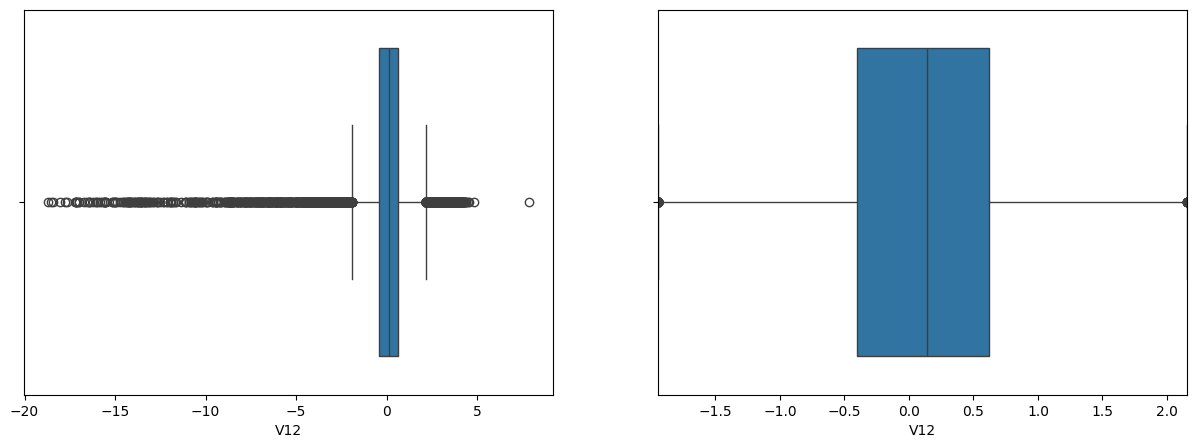

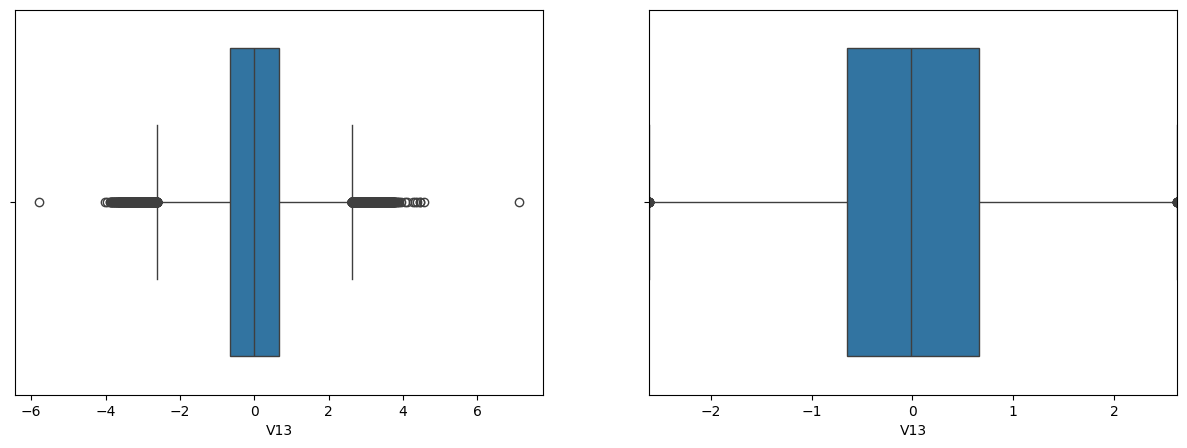

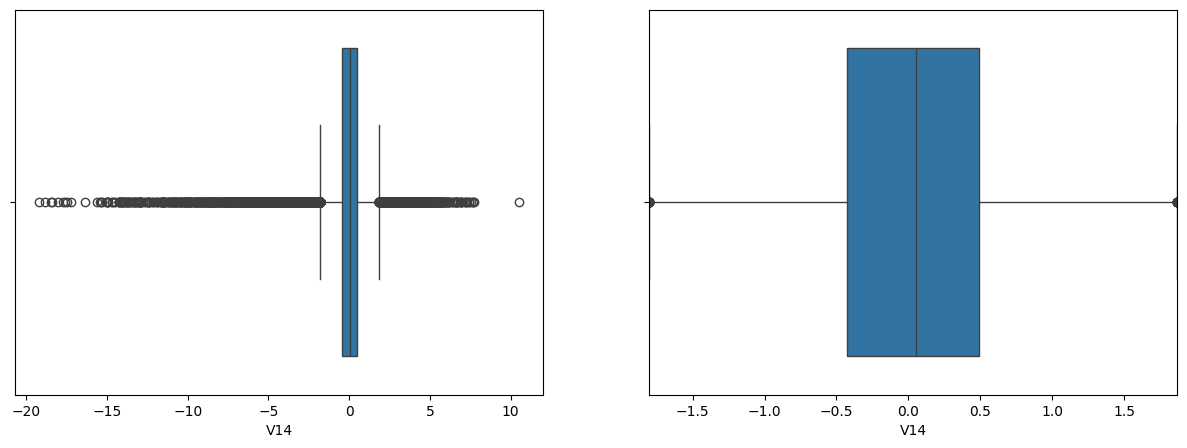

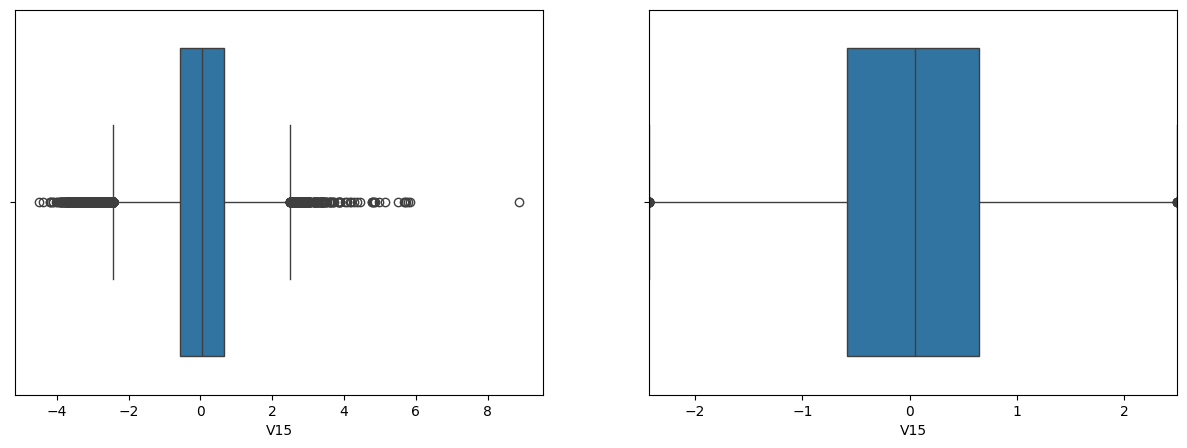

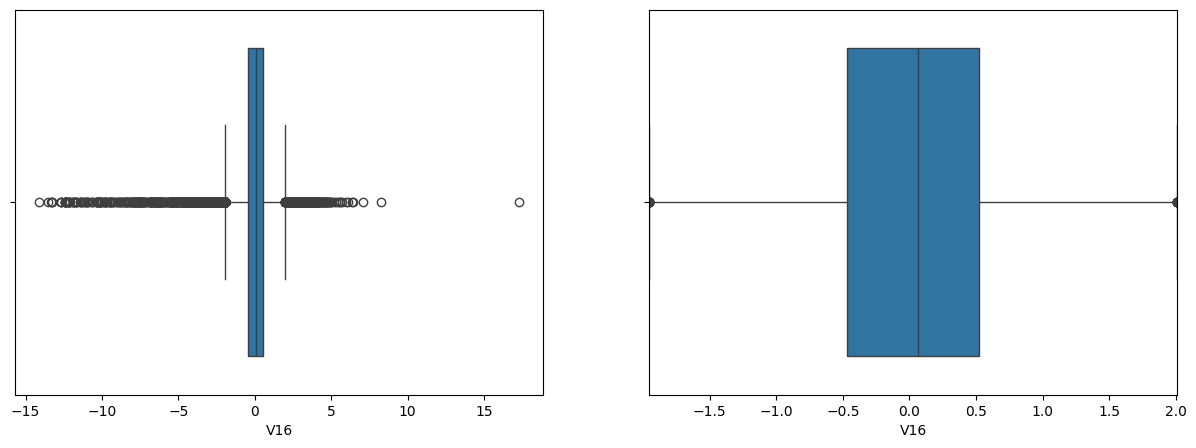

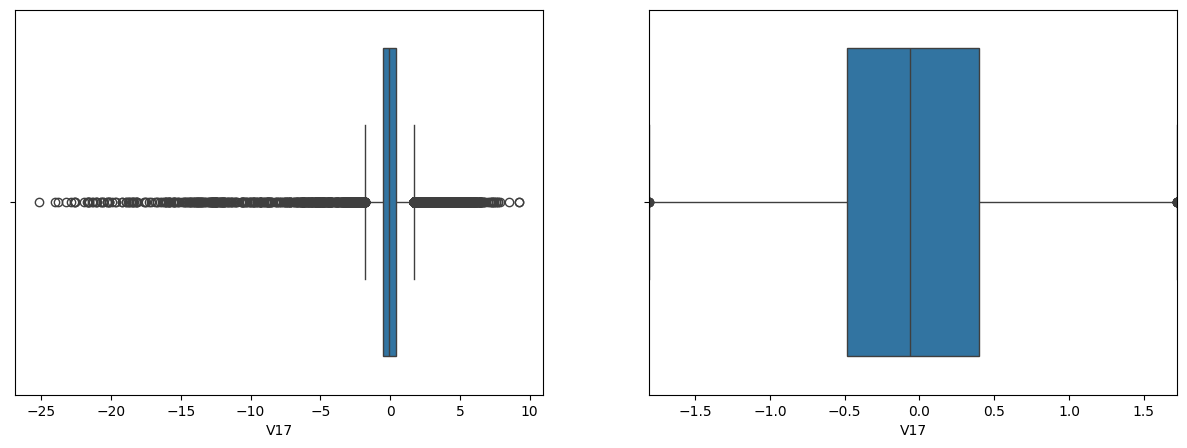

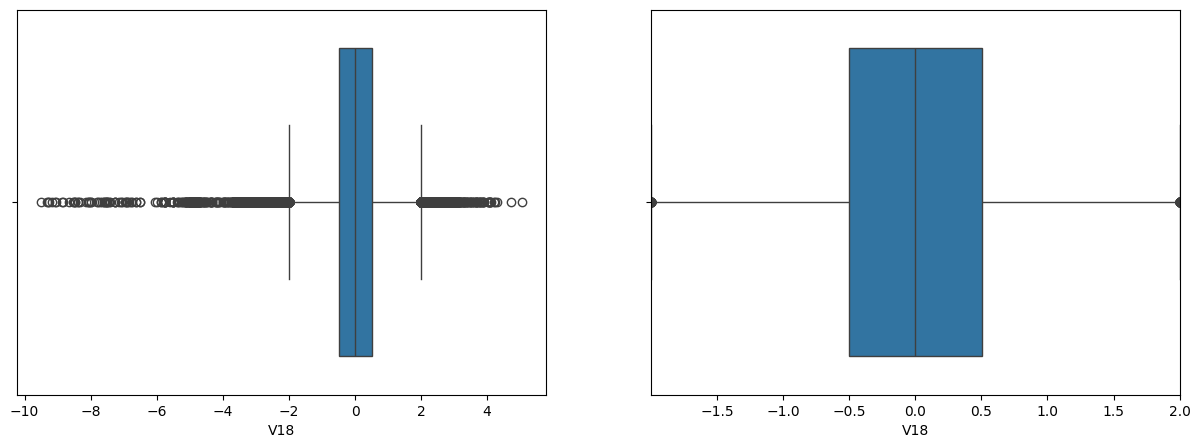

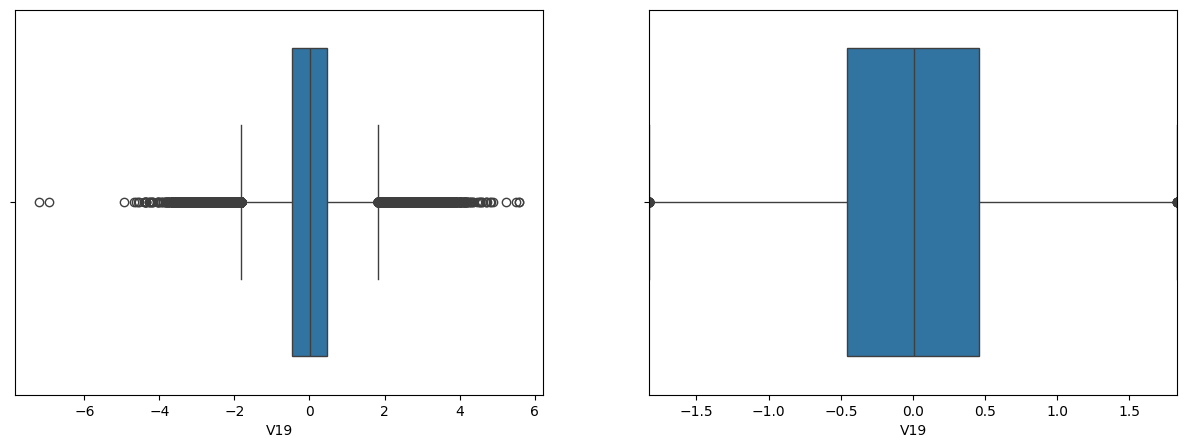

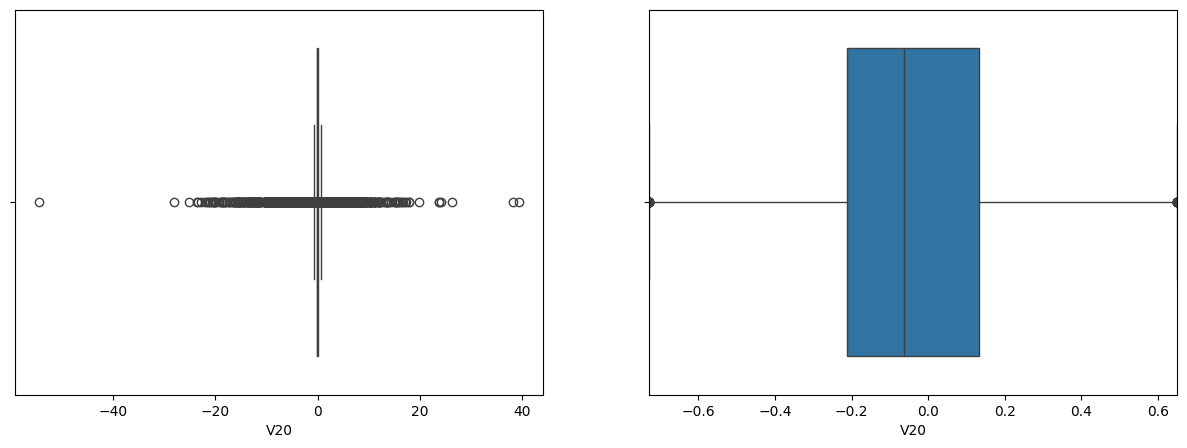

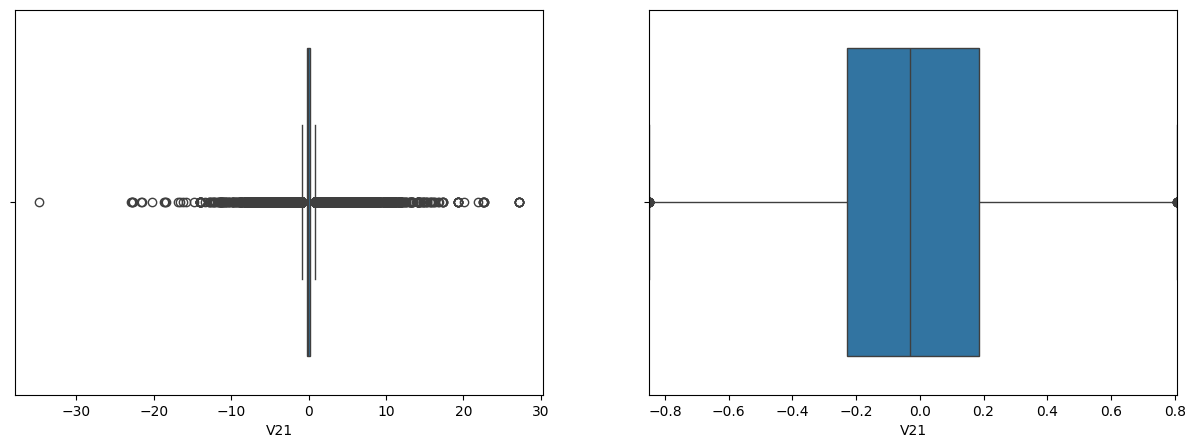

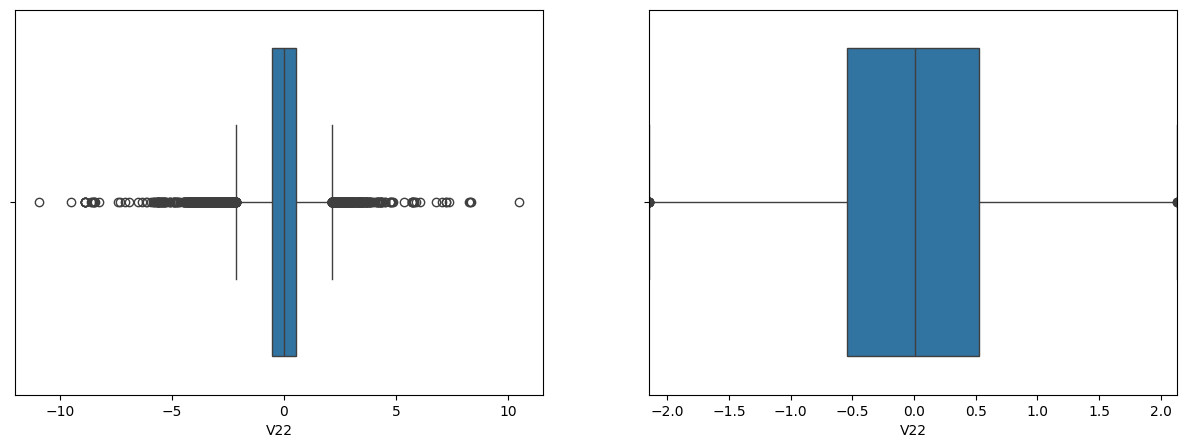

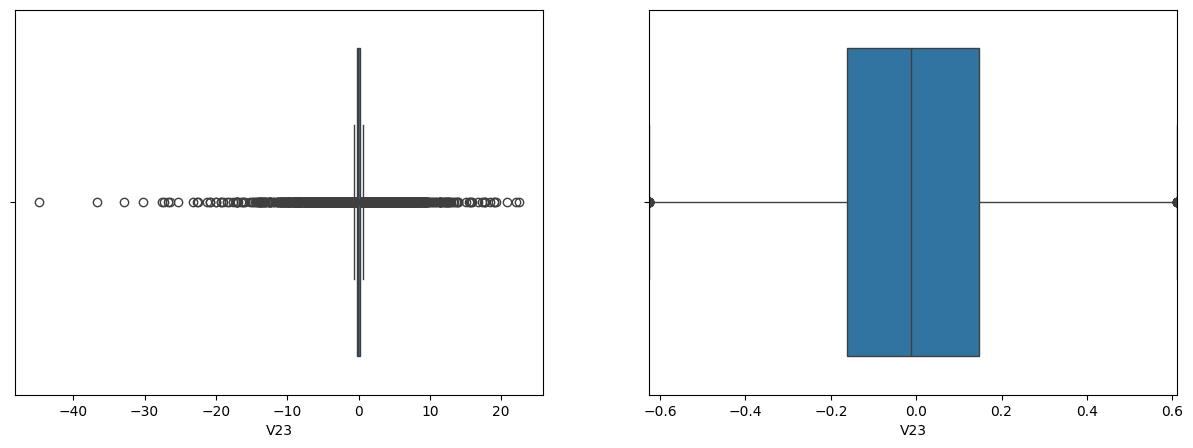

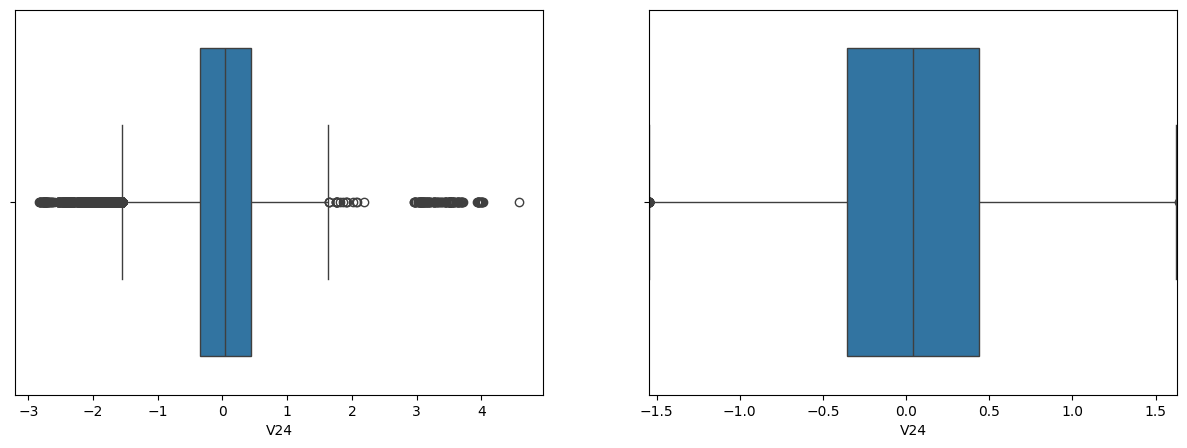

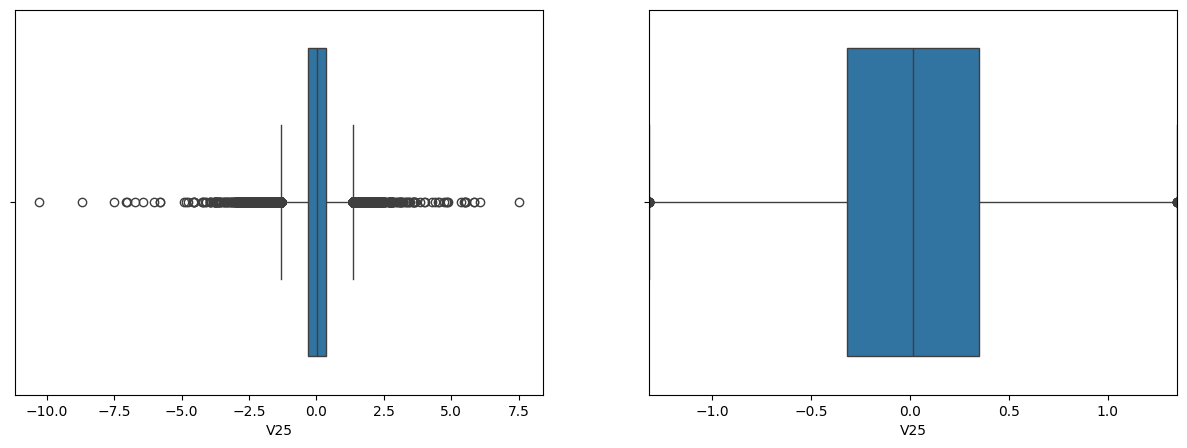

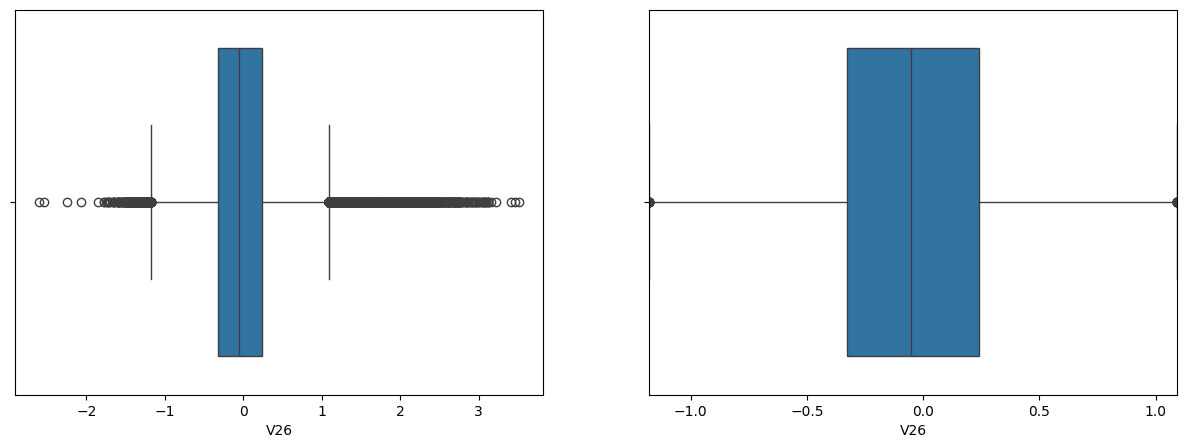

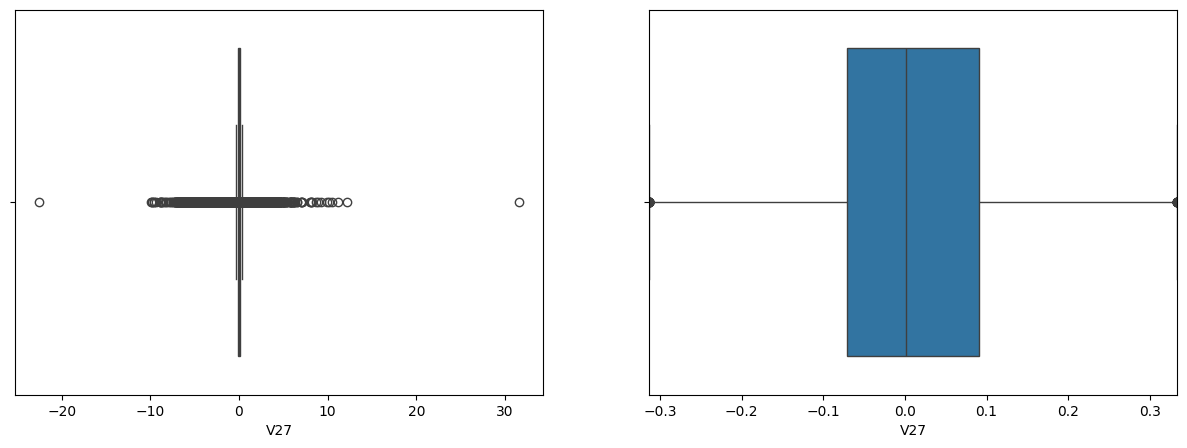

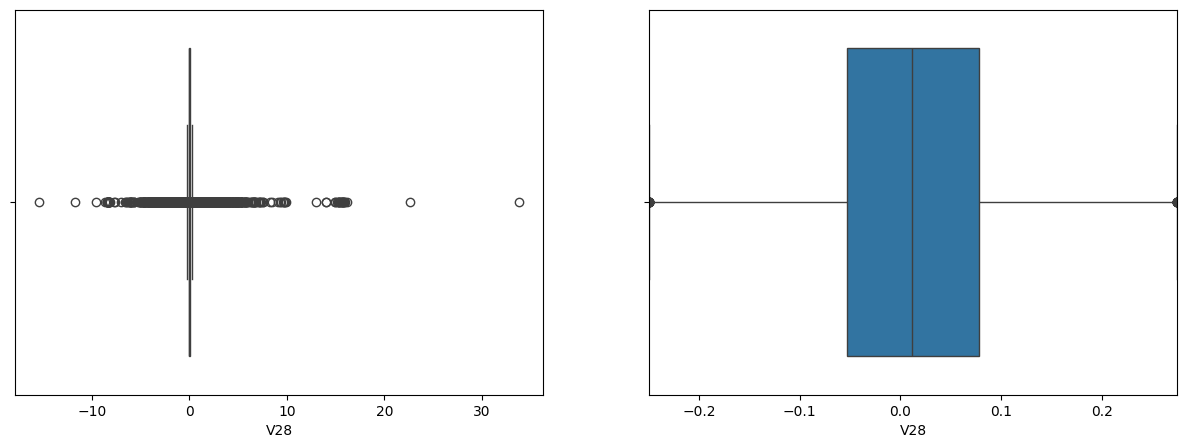

In [7]:
for columns  in features_v:
    boxplot(Data_scaled[columns])

7062 deleted lines
8438 deleted lines
1109 deleted lines
10146 deleted lines
8061 deleted lines
13618 deleted lines
2571 deleted lines
15113 deleted lines
5681 deleted lines
8034 deleted lines
92 deleted lines
10192 deleted lines
1244 deleted lines
6246 deleted lines
2059 deleted lines
5567 deleted lines
1870 deleted lines
5177 deleted lines
5505 deleted lines
8594 deleted lines


C:\Users\vinic\AppData\Local\Temp\ipykernel_10780\56588873.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,(ax1,ax2) = plt.subplots(1,2)


784 deleted lines
32 deleted lines
3642 deleted lines
2527 deleted lines
1165 deleted lines
4989 deleted lines
16970 deleted lines
7769 deleted lines


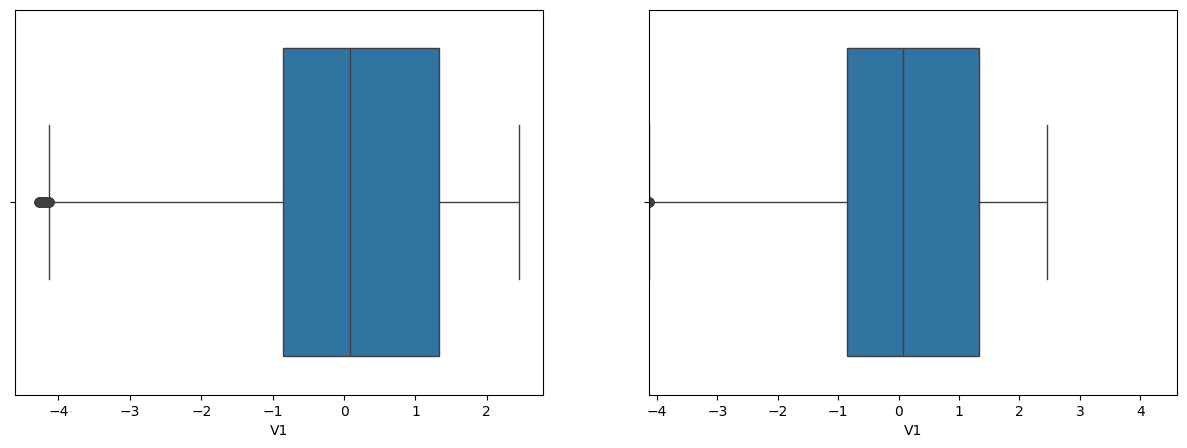

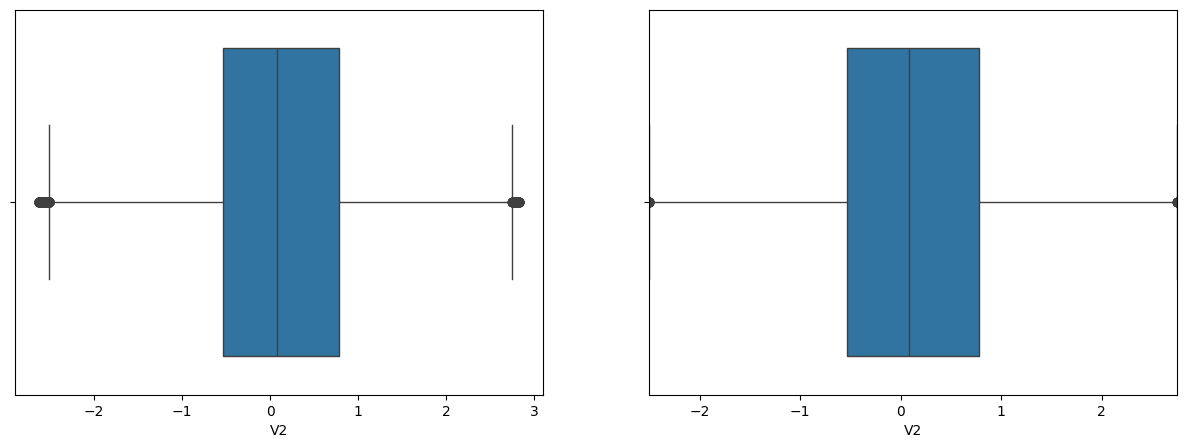

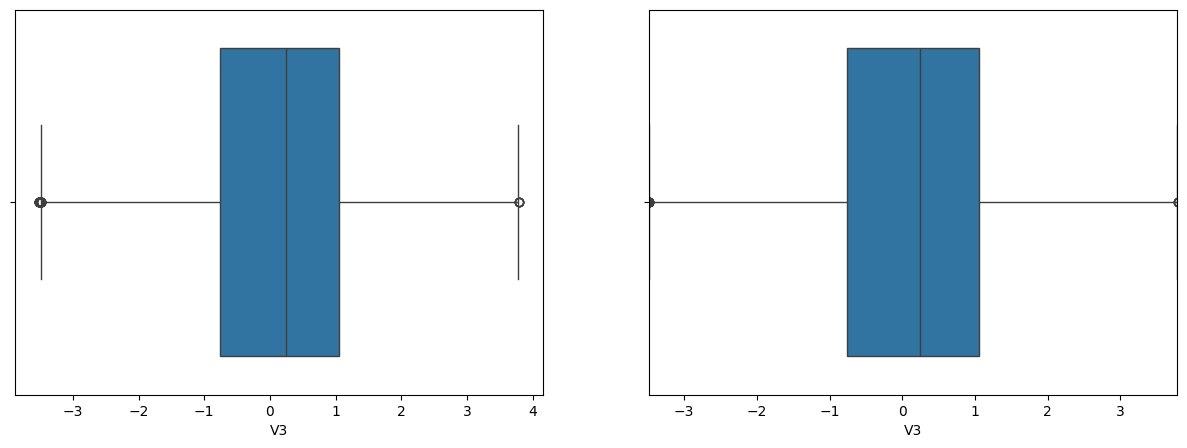

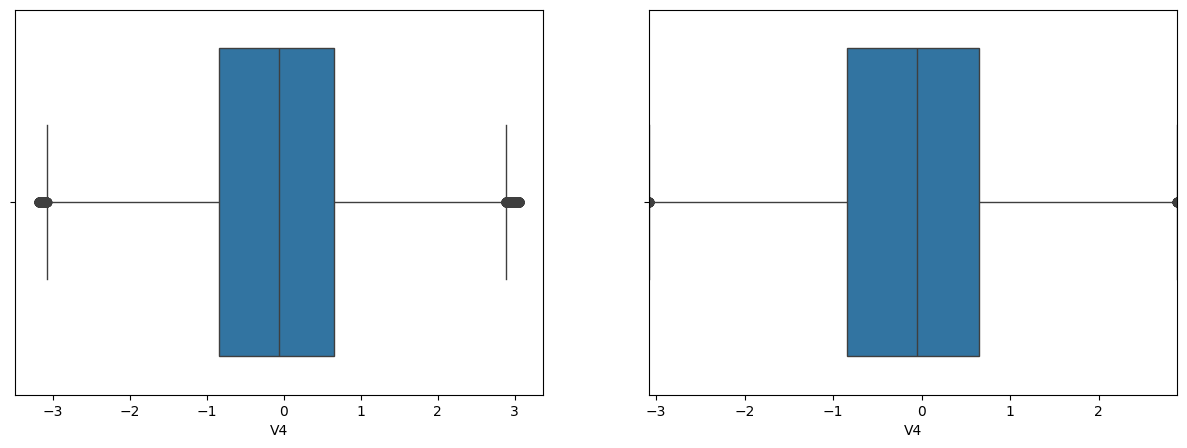

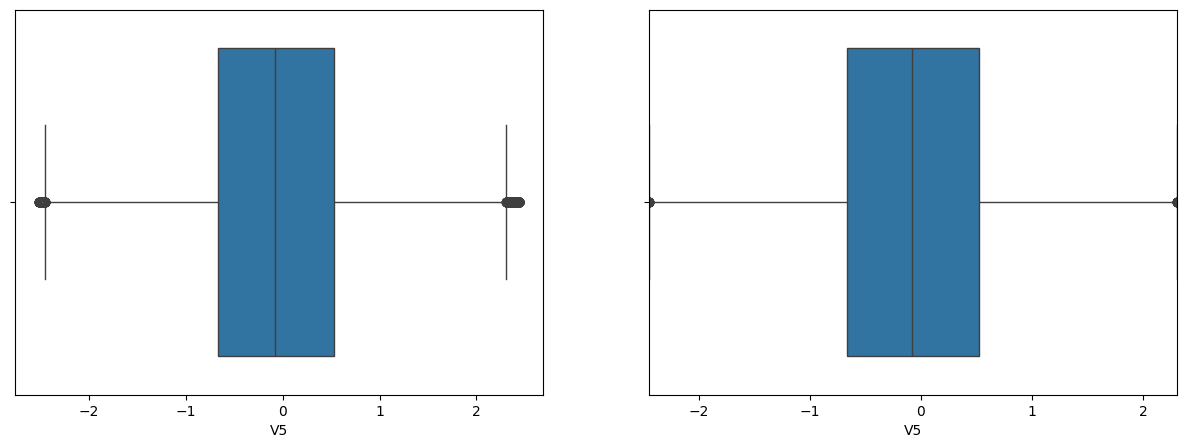

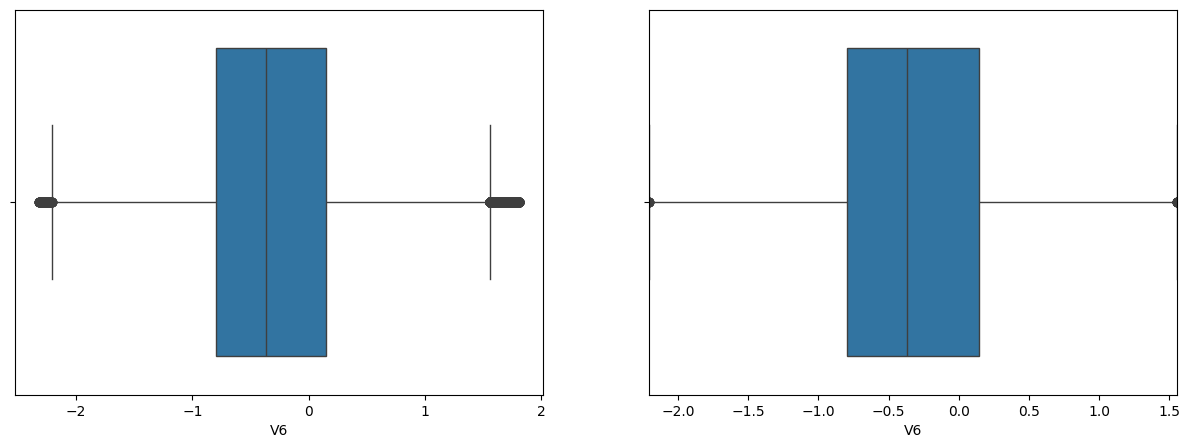

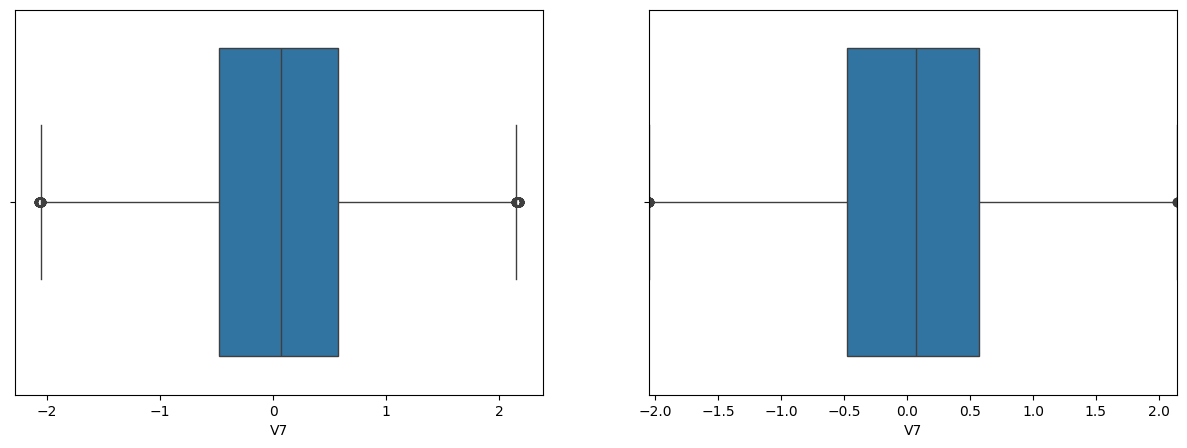

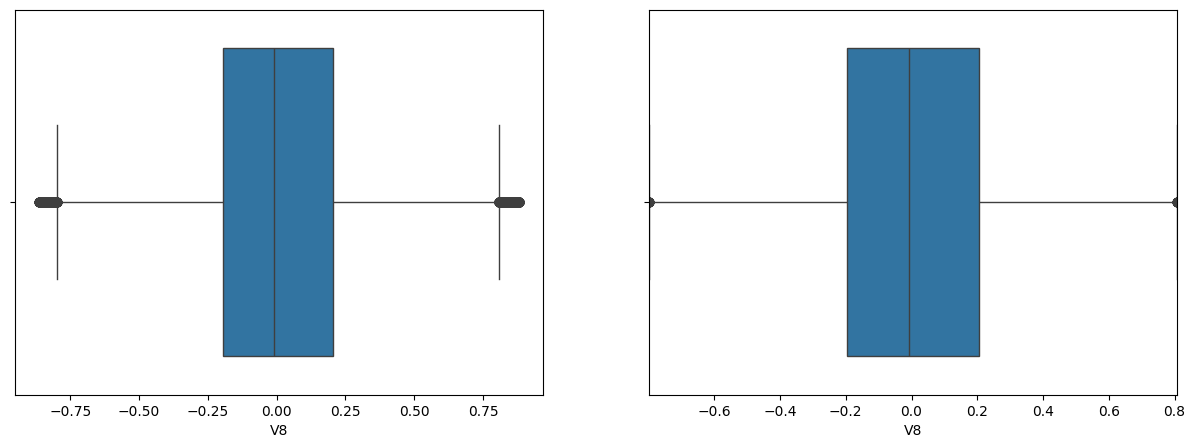

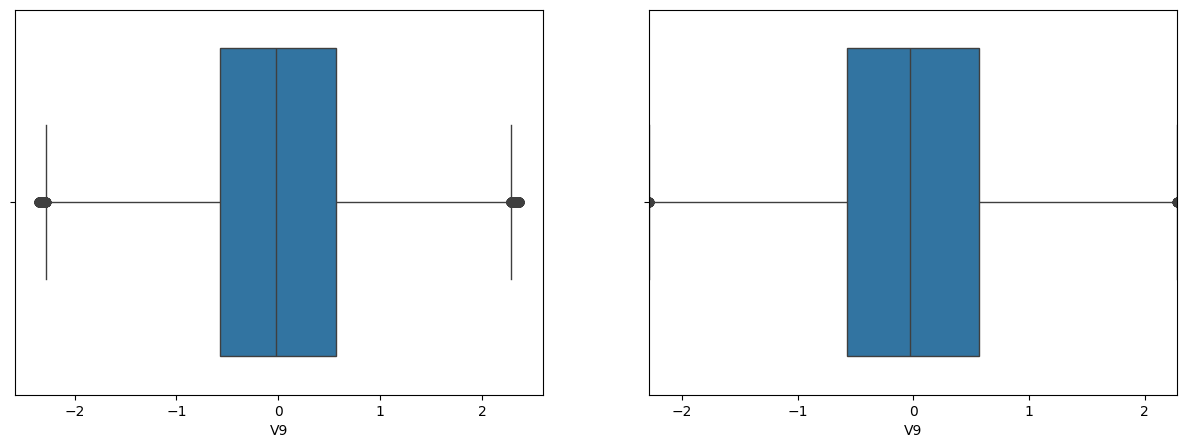

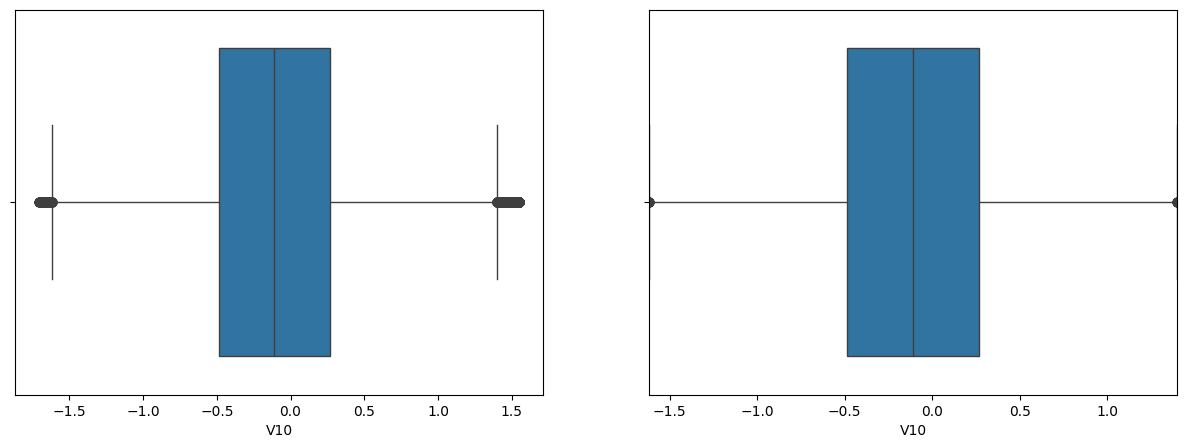

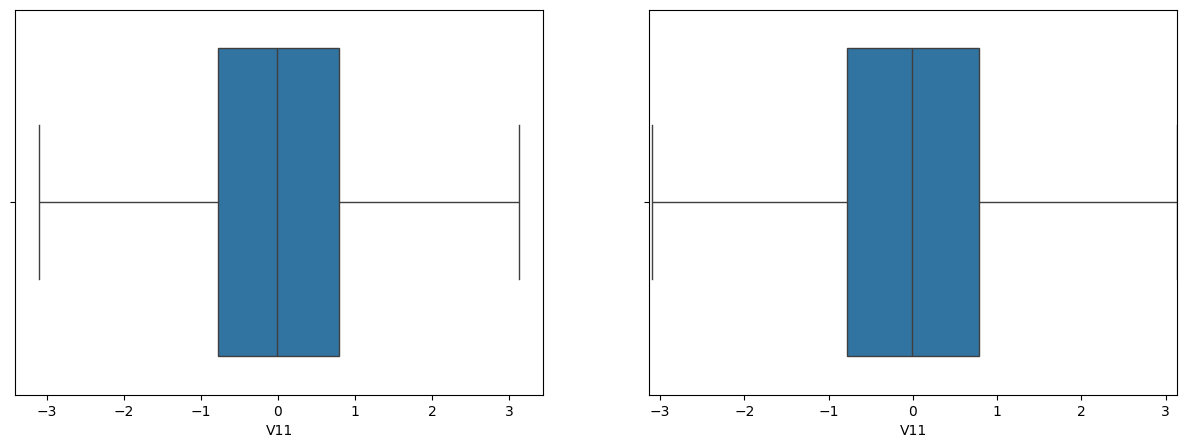

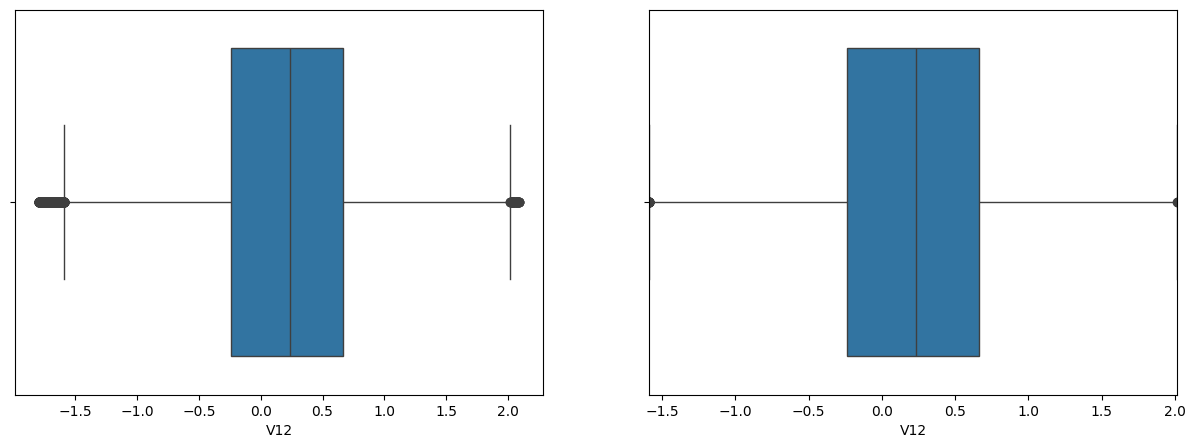

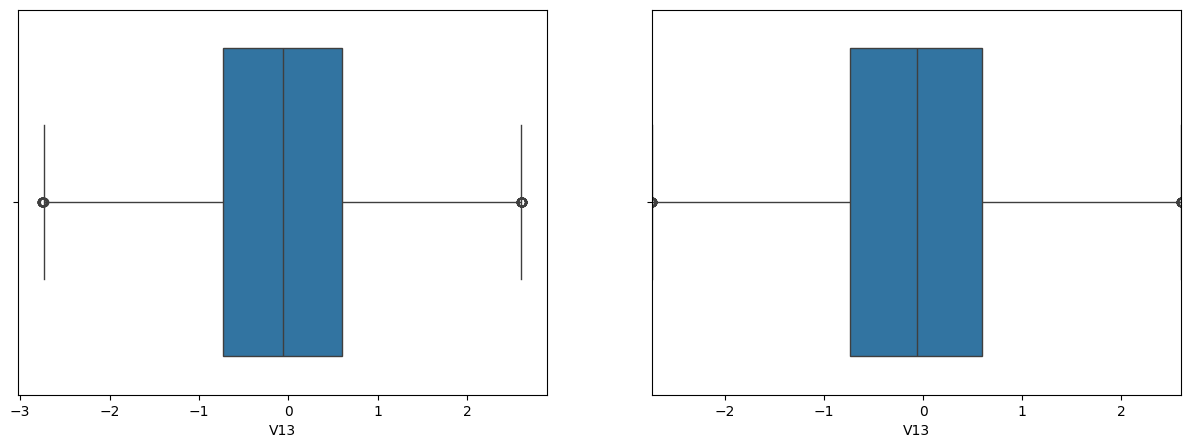

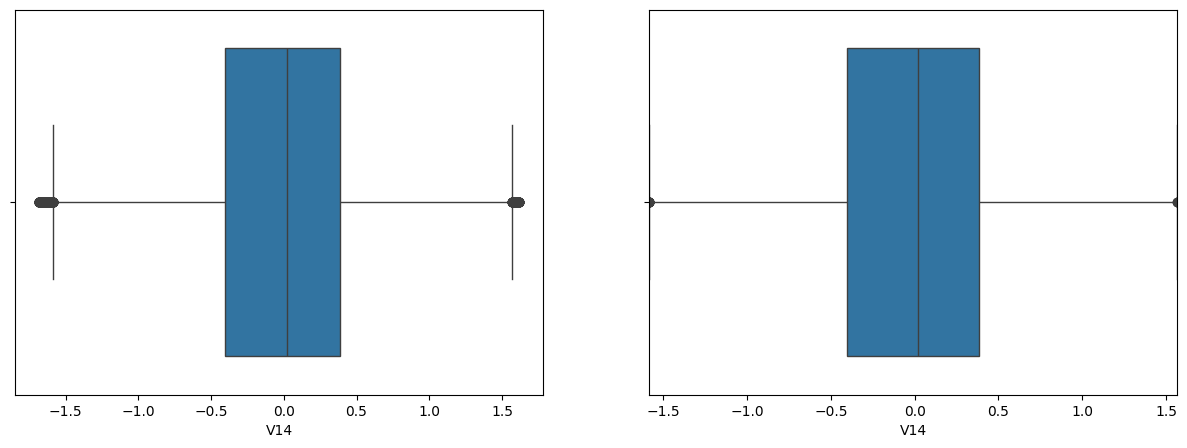

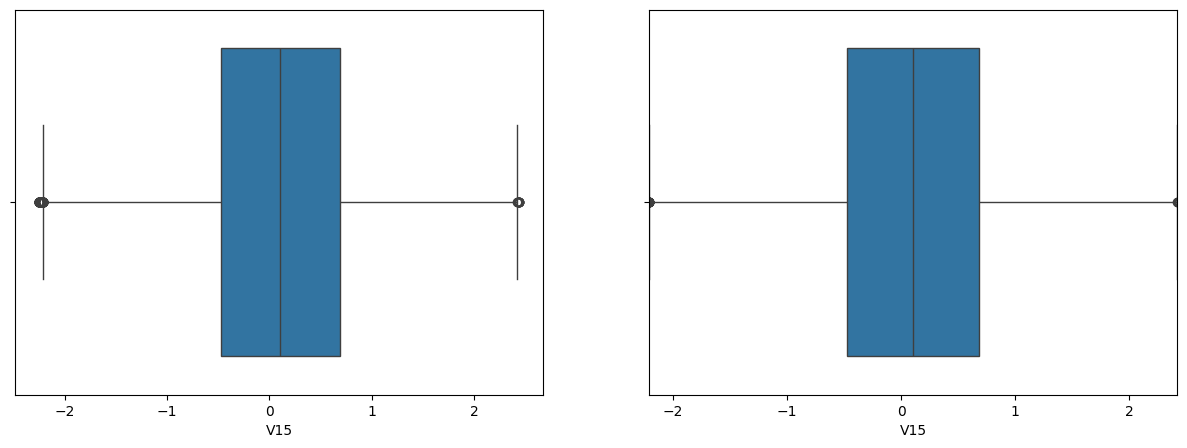

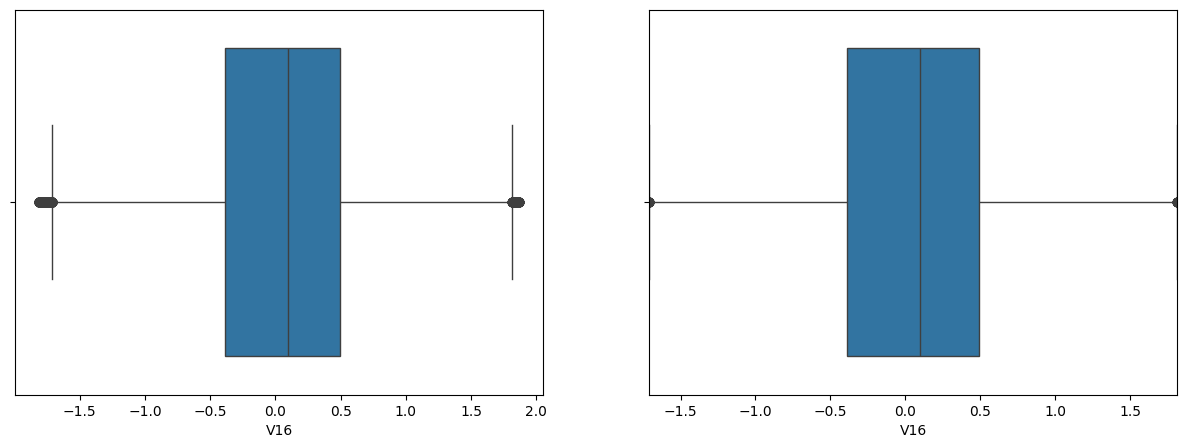

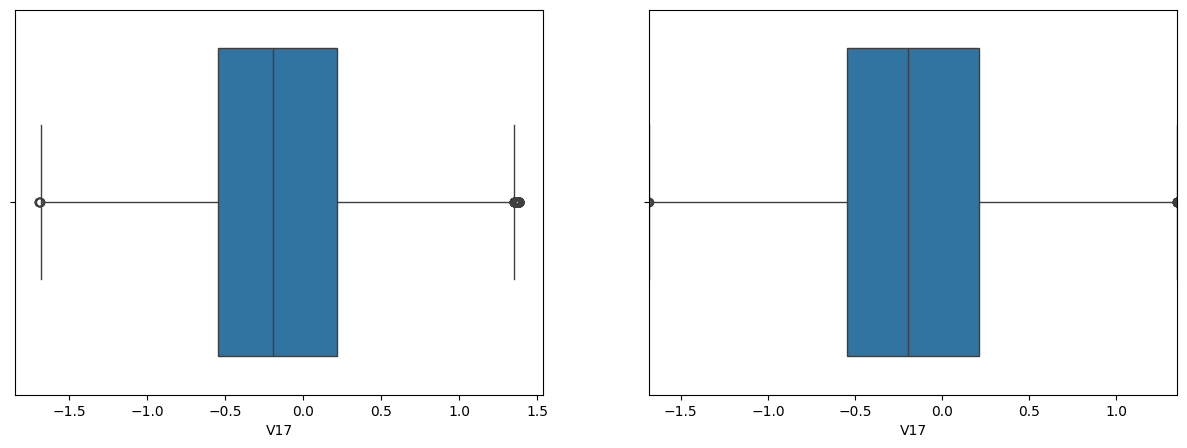

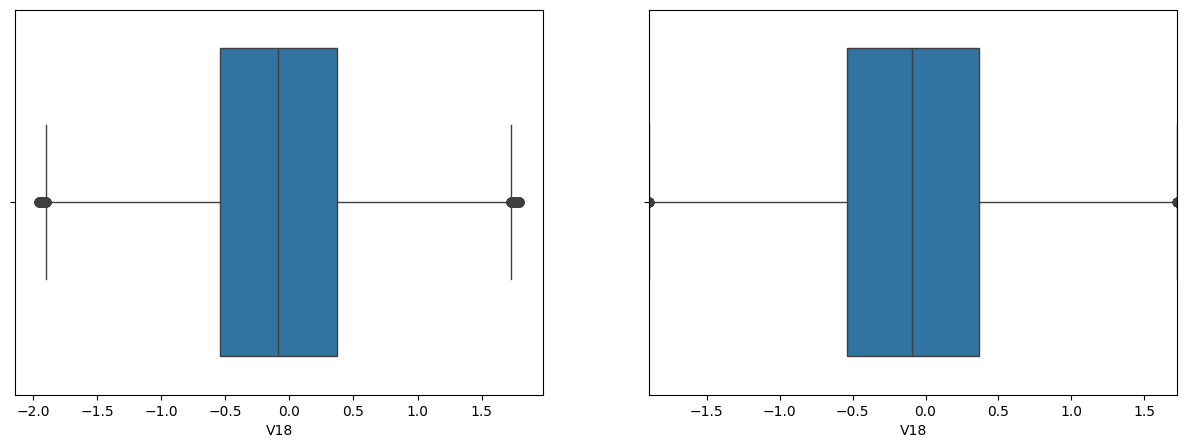

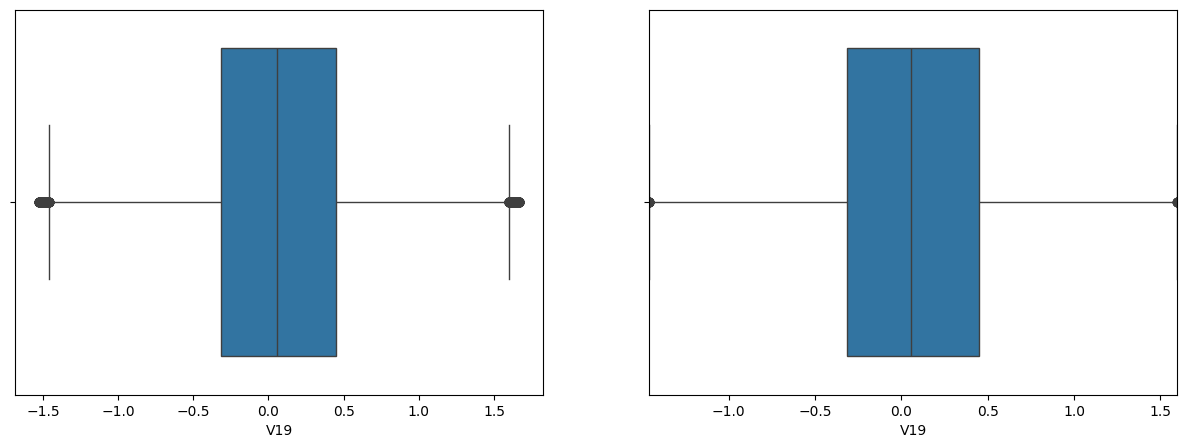

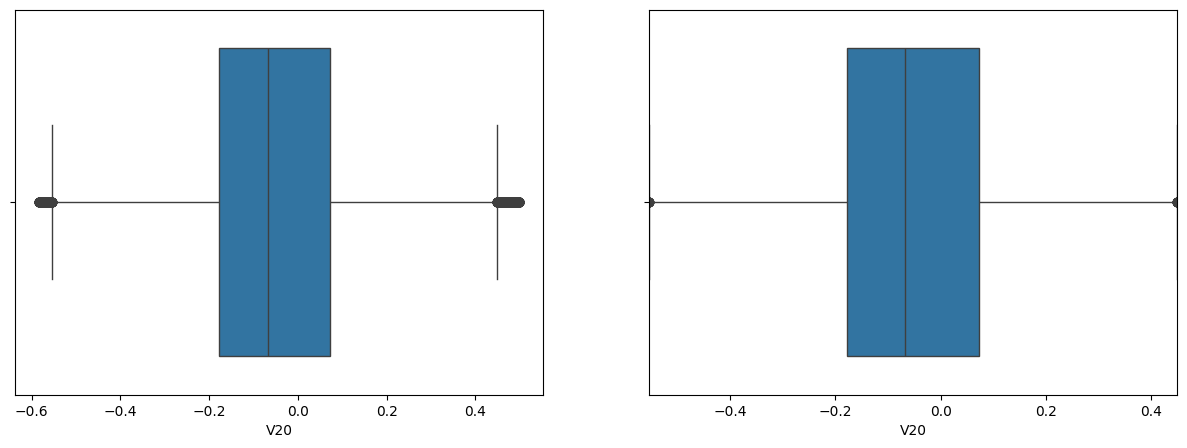

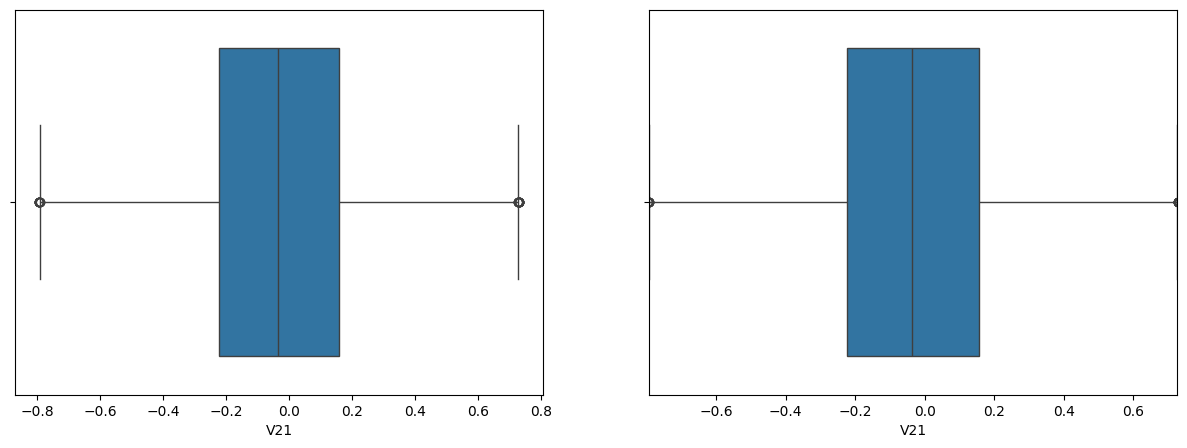

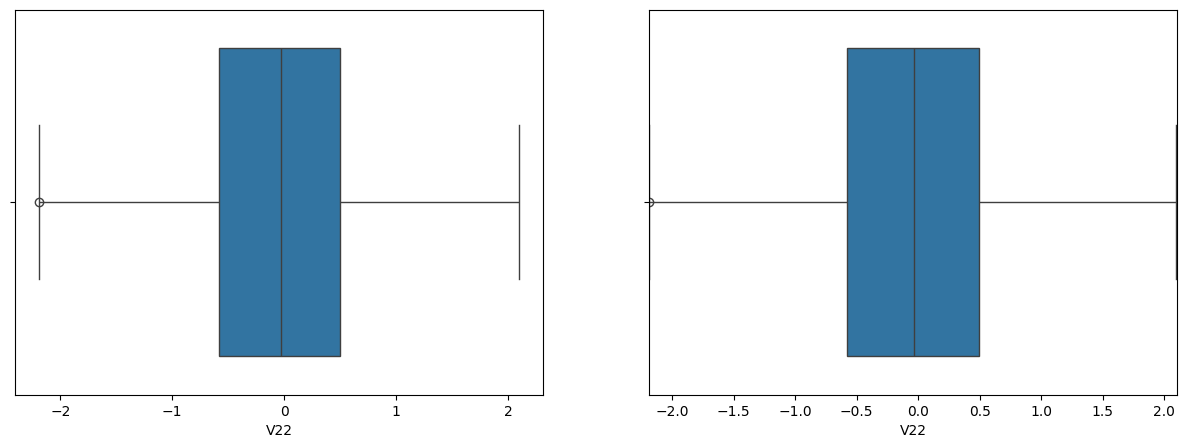

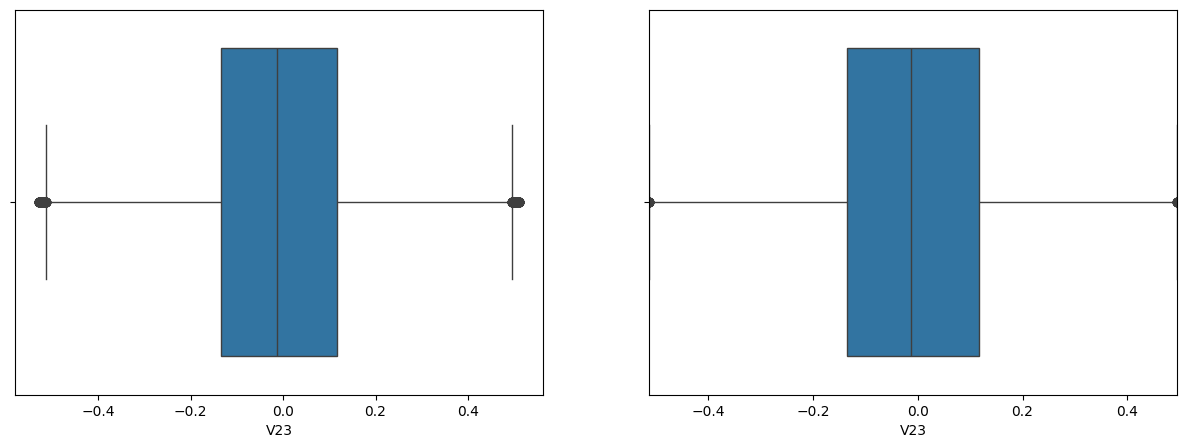

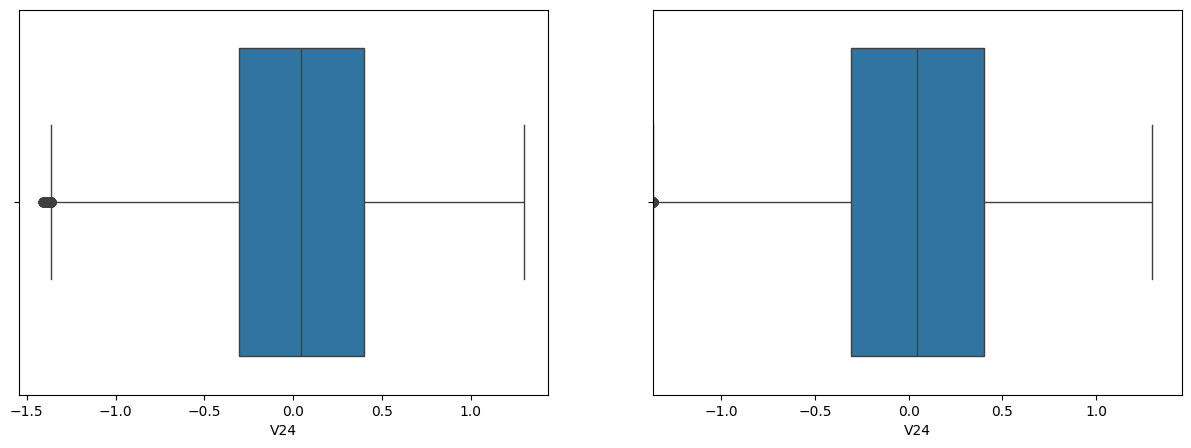

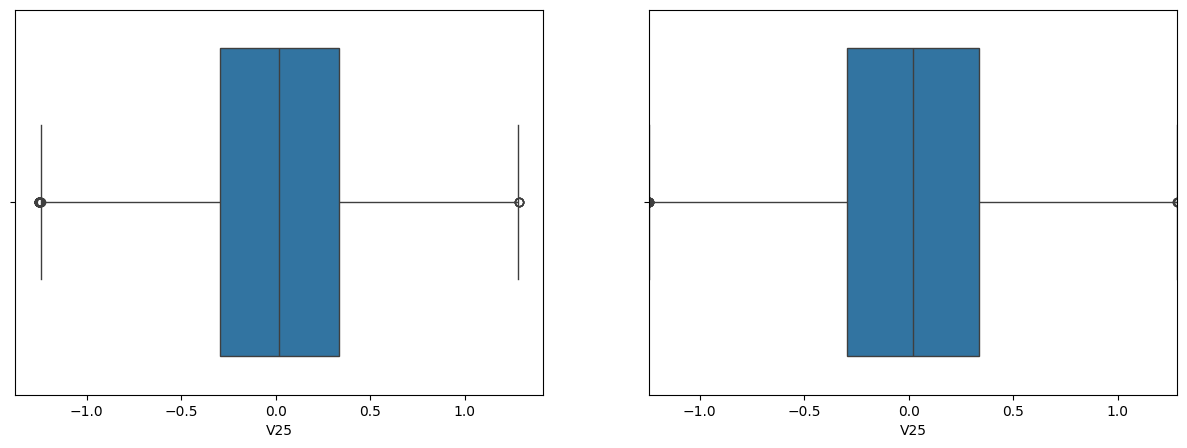

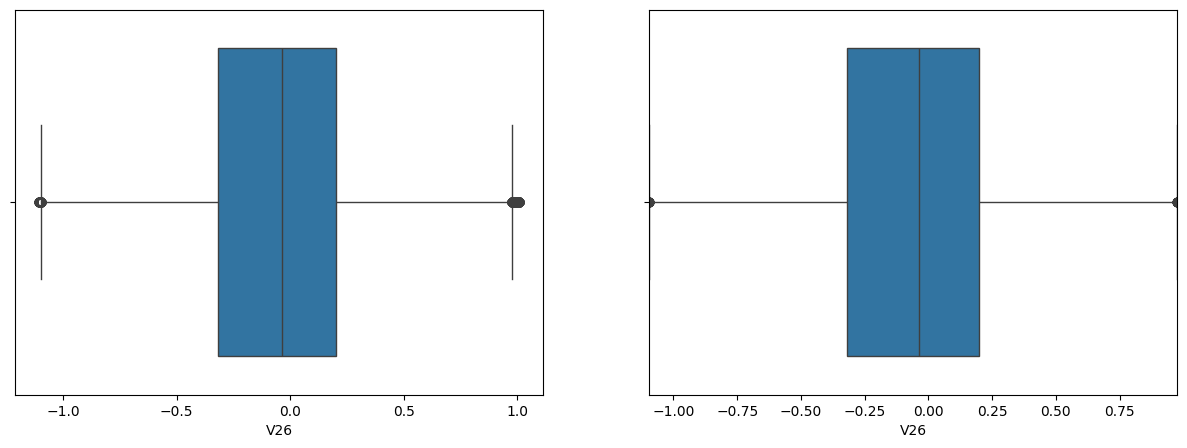

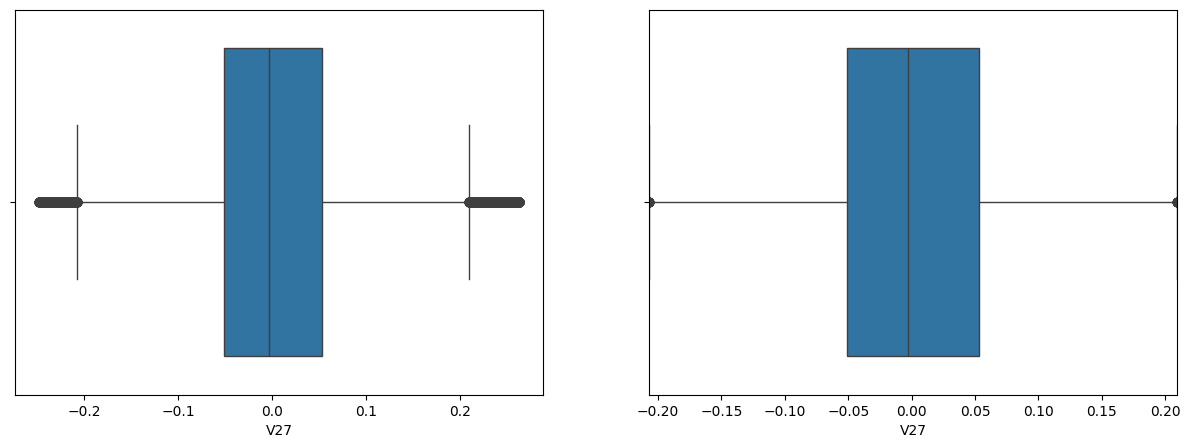

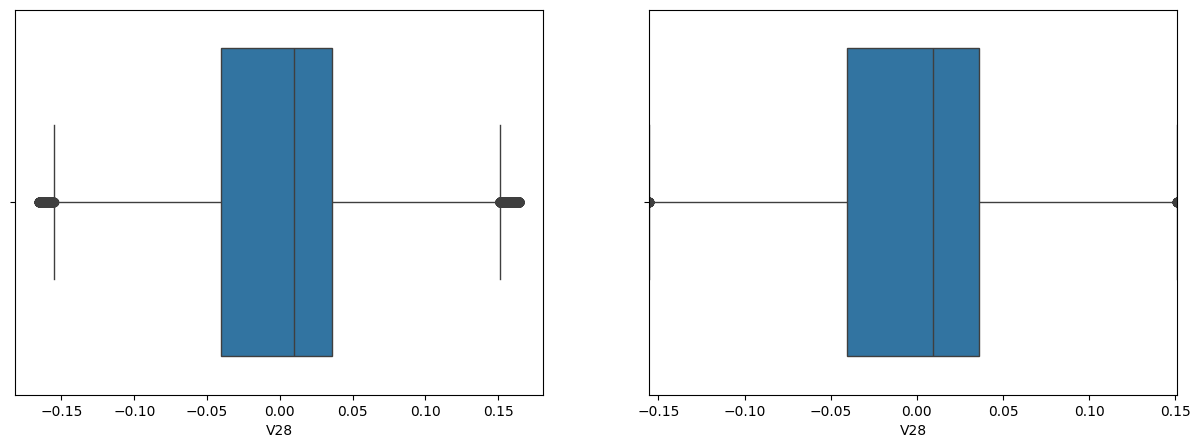

In [8]:
for column in features_v:
    Data_scaled, removed_lines = delete_outliers(Data_scaled, column)
    boxplot(Data_scaled[column])
    print(f'{removed_lines} deleted lines')


In [9]:
inspect_outliers(Data_scaled, features_v)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.253844,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.246219,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
284797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
284800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
284801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.217940,NaN,NaN,NaN,NaN


In [10]:
with pd.option_context('display.max_columns',40,
                      'display.precision',2,
                      'display.float_format',lambda numero: f'{numero:,.2f}'):
    display(Data_scaled.describe())

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
count,"120,550.00","120,550.00","120,550.00","120,550.00","120,550.00","120,550.00","120,550.00","120,550.00","120,550.00","120,550.00","120,550.00","120,550.00","120,550.00","120,550.00","120,550.00","120,550.00","120,550.00","120,550.00","120,550.00","120,550.00","120,550.00","120,550.00","120,550.00","120,550.00","120,550.00","120,550.00","120,550.00","120,550.00","120,550.00","120,550.00","120,550.00"
mean,0.86,0.00,0.06,0.12,-0.18,-0.40,0.01,0.01,0.03,-0.06,-0.02,0.25,-0.10,-0.01,0.09,0.13,-0.15,-0.11,0.05,-0.06,-0.04,-0.06,0.01,0.02,0.06,-0.02,0.01,0.00,0.00,0.32,0.12
std,1.10,0.73,1.17,1.00,0.74,0.61,0.64,0.28,0.82,0.60,0.97,0.65,0.94,0.57,0.78,0.64,0.52,0.67,0.57,0.18,0.24,0.66,0.19,0.50,0.40,0.42,0.09,0.06,0.01,0.89,0.55
min,-3.09,-2.62,-3.47,-3.18,-2.51,-2.32,-2.07,-0.86,-2.35,-1.71,-3.08,-1.79,-2.75,-1.68,-2.25,-1.81,-1.69,-1.95,-1.53,-0.58,-0.80,-2.19,-0.53,-1.41,-1.25,-1.11,-0.25,-0.17,0.00,-0.31,-0.99
25%,-0.23,-0.46,-0.75,-0.62,-0.66,-0.82,-0.45,-0.19,-0.46,-0.42,-0.81,-0.16,-0.76,-0.37,-0.44,-0.26,-0.53,-0.55,-0.31,-0.18,-0.23,-0.61,-0.12,-0.31,-0.26,-0.32,-0.05,-0.04,0.00,-0.25,-0.35
50%,1.18,0.00,0.21,0.22,-0.16,-0.46,0.05,-0.02,0.01,-0.09,-0.06,0.30,-0.07,0.04,0.12,0.16,-0.20,-0.12,0.04,-0.08,-0.05,-0.07,-0.00,0.04,0.09,-0.03,-0.00,0.01,0.00,-0.06,-0.05
75%,1.89,0.49,0.92,0.73,0.33,-0.02,0.45,0.17,0.54,0.22,0.78,0.72,0.59,0.39,0.67,0.52,0.20,0.33,0.41,0.05,0.15,0.44,0.13,0.39,0.37,0.20,0.05,0.04,0.00,0.52,0.65
max,2.38,2.78,3.79,3.06,2.43,1.81,2.18,0.88,2.37,1.55,3.06,2.09,2.62,1.62,2.43,1.87,1.38,1.79,1.67,0.50,0.73,2.05,0.51,1.30,1.29,1.01,0.26,0.16,1.00,7.78,1.04


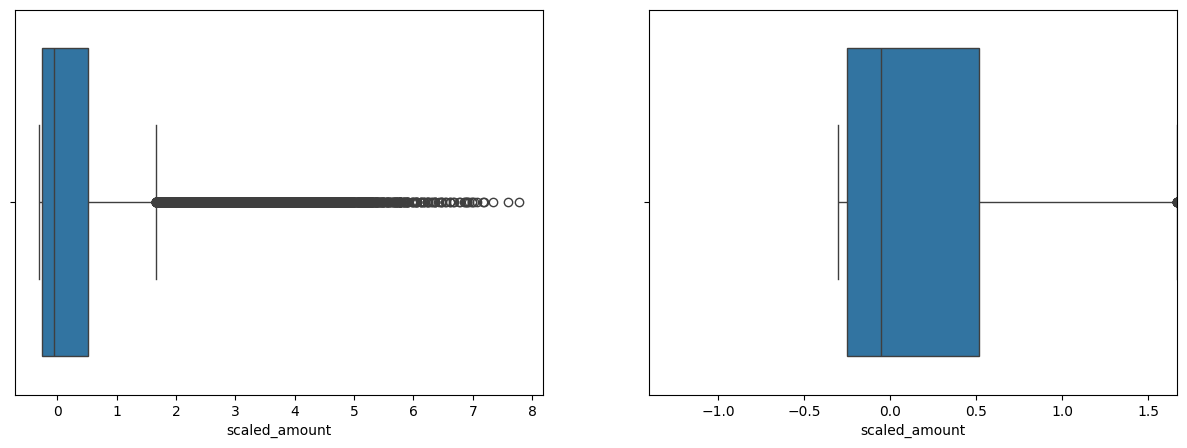

In [11]:
boxplot(Data_scaled['scaled_amount'])

In [12]:
Data_scaled

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
5,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,0,-0.256131,-0.994960
6,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,...,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,0,-0.237686,-0.994937
9,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,...,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,0,-0.255991,-0.994878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284796,1.884849,-0.143540,-0.999943,1.506772,-0.035300,-0.613638,0.190241,-0.249058,0.666458,0.120908,...,0.634646,-0.042114,-0.053206,0.316403,-0.461441,0.018265,-0.041068,0,0.530986,1.034881
284797,-0.241923,0.712247,0.399806,-0.463406,0.244531,-1.343668,0.929369,-0.206210,0.106234,-0.284708,...,-0.514376,0.279598,0.371441,-0.559238,0.113144,0.131507,0.081265,0,-0.230699,1.034904
284800,2.039560,-0.175233,-1.196825,0.234580,-0.008713,-0.726571,0.017050,-0.118228,0.435402,0.267772,...,-0.717211,0.297930,-0.359769,-0.315610,0.201114,-0.080826,-0.075071,0,-0.269964,1.034928
284801,0.120316,0.931005,-0.546012,-0.745097,1.130314,-0.235973,0.812722,0.115093,-0.204064,-0.657422,...,-0.808520,0.050343,0.102800,-0.435870,0.124079,0.217940,0.068803,0,-0.269825,1.034939


In [13]:
from pandas_profiling import ydata_profiling, ProfileReport
profile = ProfileReport(Data_scaled, title="Data_analysis_Fraud_detection_02 ")
profile.to_file("summary.html")

C:\Users\vinic\AppData\Local\Temp\ipykernel_10780\292510529.py:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ydata_profiling, ProfileReport


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
X = Data_scaled.drop('Class',axis=1)
y = Data_scaled.Class

In [15]:
RANDOM_STATE = 42

X_train , X_test , y_train , y_test = train_test_split(
    X,y,test_size=0.33,random_state=RANDOM_STATE,stratify=y
)

In [16]:
X_train.shape[0]

80768

In [17]:
y_train.shape[0]

80768

In [18]:
samplers = {
    "RUS": RandomUnderSampler(random_state=RANDOM_STATE),
    "ROS": RandomOverSampler(random_state=RANDOM_STATE),
}

In [19]:
def resampling(X,y,sampler,model,kf):
      # ColumnTransformer
    preprocessing = ColumnTransformer(
        transformers=[
            ("rob_scaler", RobustScaler(), ["scaled_time", "scaled_amount"]),
        ],
        remainder="passthrough"
    )
    pipeline = Pipeline(
    [
        ('preprossesing',preprocessing),
        ('sampler',sampler),
        ('model',model),
        
    ]
)
    
    param_grid = {
        'sampler__sampling_strategy':['auto',0.5,0.75,1],
        'model__C':np.logspace(-3,3,7),
        'model__penalty':['11','12','elasticnet',None],
        'model__solver':['lbfgs','saga']
    }
    
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        scoring=['recall','average_precision'],
        refit='average_precision',
        cv=kf,
        #n_jobs=  if you dont have a good machine
        verbose=1
    )
    
    scores = cross_validate(
        pipeline,
        X,
        y,
        cv=kf,
        scoring=["accuracy", "precision", "recall", "roc_auc", "average_precision"],
        n_jobs=-1,
    )
 
    return scores

In [20]:
models = {
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "LogisticRegression": LogisticRegression(random_state=RANDOM_STATE),
    "KNNClassifier": KNeighborsClassifier(n_neighbors=5),
}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [21]:
resultados_rus = {
    "DecisionTreeClassifier": resampling(
        X, y, samplers["RUS"], models["DecisionTreeClassifier"], skf
    ),
    "LogisticRegression": resampling(
        X, y, samplers["RUS"], models["LogisticRegression"], skf
    ),
    "KNNClassifier": resampling(X, y, samplers["RUS"], models["KNNClassifier"], skf),
}

In [22]:
resultados_ros = {
    "DecisionTreeClassifier": resampling(
        X, y, samplers["ROS"], models["DecisionTreeClassifier"], skf
    ),
    "LogisticRegression": resampling(
        X, y, samplers["ROS"], models["LogisticRegression"], skf
    ),
    "KNNClassifier": resampling(X, y, samplers["ROS"], models["KNNClassifier"], skf),
}

In [23]:
for k ,v in resultados_rus.items():
    print(k)
    resultados_rus[k]['time'] = resultados_rus[k]['fit_time'] +resultados_rus[k][
        "score_time"
    ]
for k , v in resultados_ros.items():
    resultados_ros[k]['time'] = resultados_ros[k]['fit_time'] +resultados_ros[k][
        "score_time"
    ]
    

DecisionTreeClassifier
LogisticRegression
KNNClassifier


In [24]:
df_rus = pd.DataFrame(resultados_rus).T.assign(sampler="RUS").reset_index().rename(
    columns={"index": "modelo"}
)
df_ros = pd.DataFrame(resultados_ros).T.assign(sampler="ROS").reset_index().rename(
    columns={"index": "modelo"}
)


In [25]:
df_resultados = pd.concat([df_rus, df_ros]).reset_index(drop=True)

In [26]:
df_resultados.head()

,modelo,fit_time,score_time,test_accuracy,test_precision,test_recall,test_roc_auc,test_average_precision,time,sampler
0,DecisionTreeClassifier,"[0.07632684707641602, 0.08829140663146973, 0.1...","[0.05883479118347168, 0.05684161186218262, 0.0...","[0.5272501036914143, 0.53372044794691, 0.59767...","[0.0, 0.00017787264318747776, 0.00020616431295...","[0.0, 1.0, 0.6666666666666666, 0.0, 1.0]","[0.26364692218350755, 0.7668408826945412, 0.63...","[8.295313148071339e-05, 0.00017787264318747776...","[0.1351616382598877, 0.14513301849365234, 0.15...",RUS
1,LogisticRegression,"[0.0643162727355957, 0.1156773567199707, 0.106...","[0.03798246383666992, 0.05136919021606445, 0.0...","[0.6215263376192451, 0.6388220655329738, 0.670...","[0.00010958904109589041, 0.0001148369315571887...","[0.5, 0.5, 0.6666666666666666, 0.3333333333333...","[0.7029616724738675, 0.6653185664509706, 0.808...","[0.0006510065146931554, 0.00029319238854012754...","[0.10229873657226562, 0.16704654693603516, 0.1...",RUS
2,KNNClassifier,"[0.1341261863708496, 0.11473274230957031, 0.11...","[0.7133693695068359, 0.7555441856384277, 0.751...","[0.40331812525922855, 0.6129406885109913, 0.49...","[6.951202558042541e-05, 0.00010715816545220746...","[0.5, 0.5, 1.0, 1.0, 0.3333333333333333]","[0.5655798904927825, 0.5886946241911398, 0.773...","[0.00012414512172348707, 0.0003207059346087303...","[0.8474955558776855, 0.870276927947998, 0.8706...",RUS
3,DecisionTreeClassifier,"[4.897968292236328, 3.796969175338745, 4.22422...","[0.03889274597167969, 0.047960519790649414, 0....","[0.9998340937370386, 0.9997926171712982, 0.999...","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.4999585199933632, 0.4999377799900448, 0.499...","[8.295313148071339e-05, 8.295313148071339e-05,...","[4.936861038208008, 3.8449296951293945, 4.2631...",ROS
4,LogisticRegression,"[3.590862274169922, 3.7029945850372314, 3.7339...","[0.05908989906311035, 0.04100346565246582, 0.0...","[0.9111571961841559, 0.9361260887598507, 0.912...","[0.00046685340802987864, 0.0, 0.00047483380816...","[0.5, 0.0, 0.3333333333333333, 0.0, 0.66666666...","[0.8774680603948897, 0.469035175045628, 0.7190...","[0.0007144460408611689, 0.00018285603125968404...","[3.6499521732330322, 3.7439980506896973, 3.776...",ROS


In [27]:
list_columns = df_resultados.columns[1:-1].tolist()

In [28]:
df_resultados = df_resultados.explode(list_columns)

In [29]:
df_results_explode = df_resultados.explode(list_columns).reset_index(drop=True)

In [30]:
df_results_explode.head()

,modelo,fit_time,score_time,test_accuracy,test_precision,test_recall,test_roc_auc,test_average_precision,time,sampler
0,DecisionTreeClassifier,0.076327,0.058835,0.52725,0.0,0.0,0.263647,0.000083,0.135162,RUS
1,DecisionTreeClassifier,0.088291,0.056842,0.53372,0.000178,1.0,0.766841,0.000178,0.145133,RUS
2,DecisionTreeClassifier,0.107699,0.047918,0.597677,0.000206,0.666667,0.632168,0.000179,0.155617,RUS
3,DecisionTreeClassifier,0.109694,0.047918,0.585649,0.0,0.0,0.292861,0.000124,0.157611,RUS
4,DecisionTreeClassifier,0.106753,0.046872,0.531149,0.000265,1.0,0.765545,0.000265,0.153625,RUS


In [31]:
df_results_explode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   modelo                  30 non-null     object
 1   fit_time                30 non-null     object
 2   score_time              30 non-null     object
 3   test_accuracy           30 non-null     object
 4   test_precision          30 non-null     object
 5   test_recall             30 non-null     object
 6   test_roc_auc            30 non-null     object
 7   test_average_precision  30 non-null     object
 8   time                    30 non-null     object
 9   sampler                 30 non-null     object
dtypes: object(10)
memory usage: 2.5+ KB


In [32]:
df_results_explode = df_results_explode.apply(pd.to_numeric,errors='ignore')

C:\Users\vinic\AppData\Local\Temp\ipykernel_10780\2658370007.py:1: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_results_explode = df_results_explode.apply(pd.to_numeric,errors='ignore')


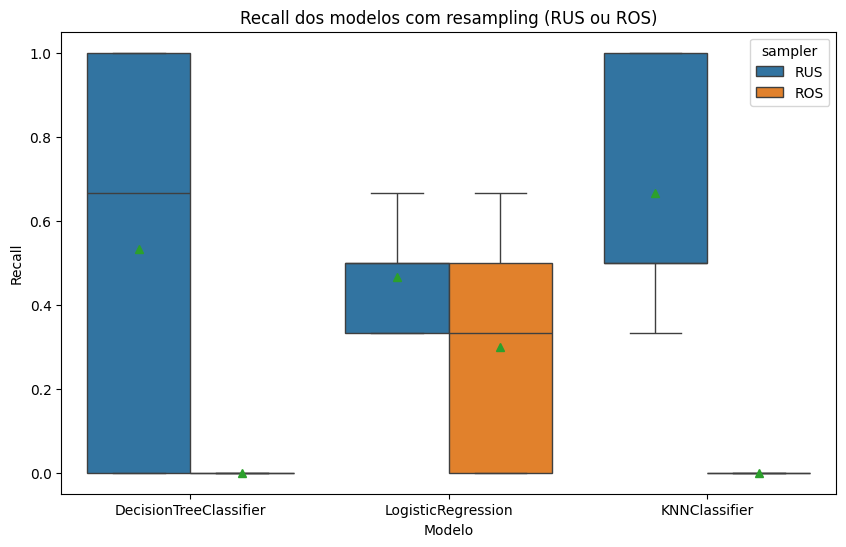

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(
    x="modelo",
    y="test_recall",
    hue="sampler",
    data=df_results_explode,
    ax=ax,
    showmeans=True,
)

ax.set_title("Recall dos modelos com resampling (RUS ou ROS)")
ax.set_xlabel("Modelo")
ax.set_ylabel("Recall")

plt.show()

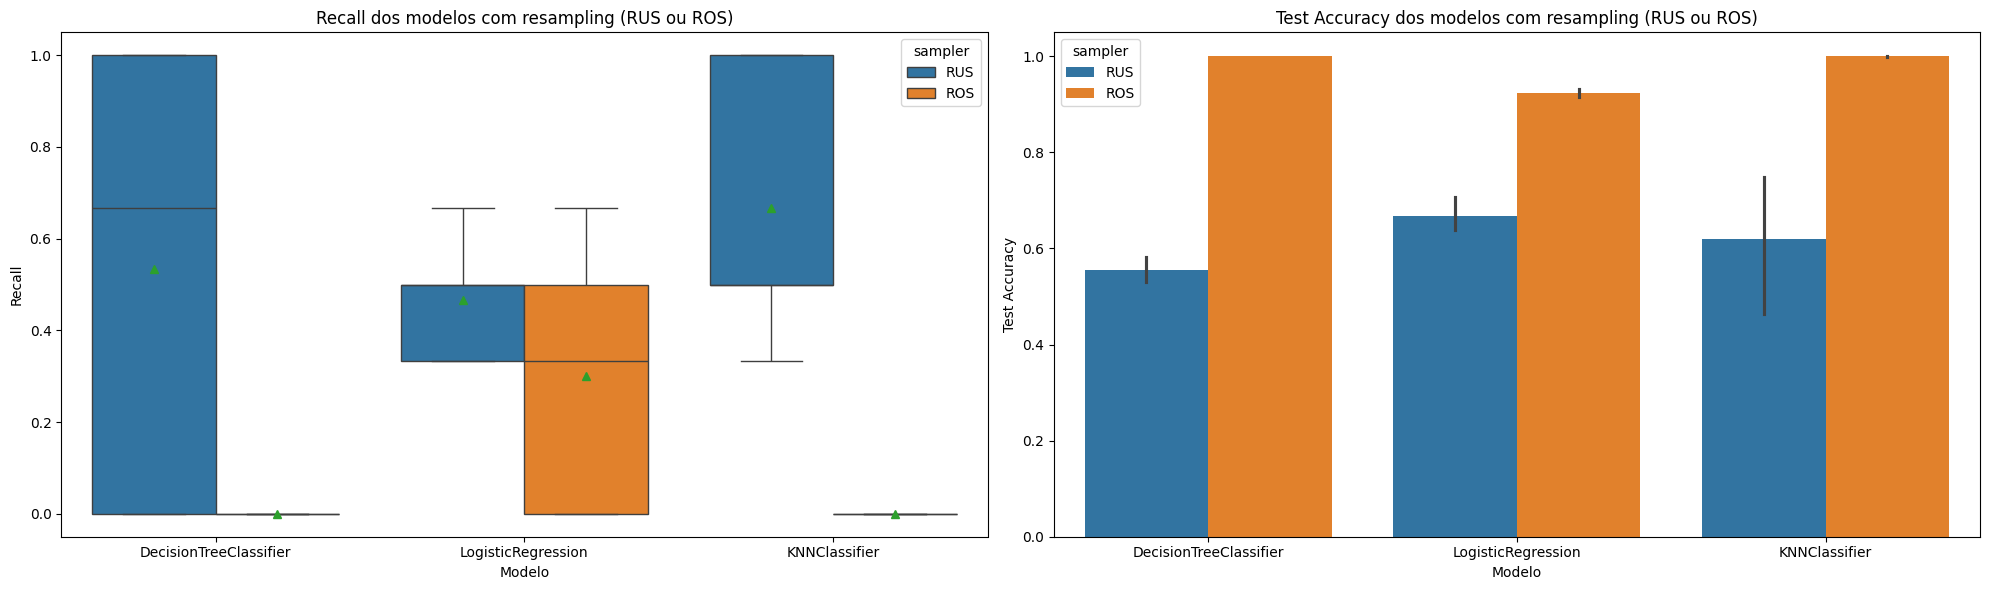

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(20, 6))
sns.boxplot(
    x="modelo",
    y="test_recall",
    hue="sampler",
    data=df_results_explode,
    ax=axes[0],
    showmeans=True,
)
axes[0].set_title("Recall dos modelos com resampling (RUS ou ROS)")
axes[0].set_xlabel("Modelo")
axes[0].set_ylabel("Recall")
sns.barplot(
    x="modelo",
    y="test_accuracy",
    hue="sampler",
    data=df_results_explode,
    ax=axes[1],
)
axes[1].set_title("Test Accuracy dos modelos com resampling (RUS ou ROS)")
axes[1].set_xlabel("Modelo")
axes[1].set_ylabel("Test Accuracy")
plt.tight_layout()
plt.show()


In [35]:
columns_scoring = ['test_precision','test_accuracy','test_roc_auc','test_average_precision'
                  'time'
                  ]

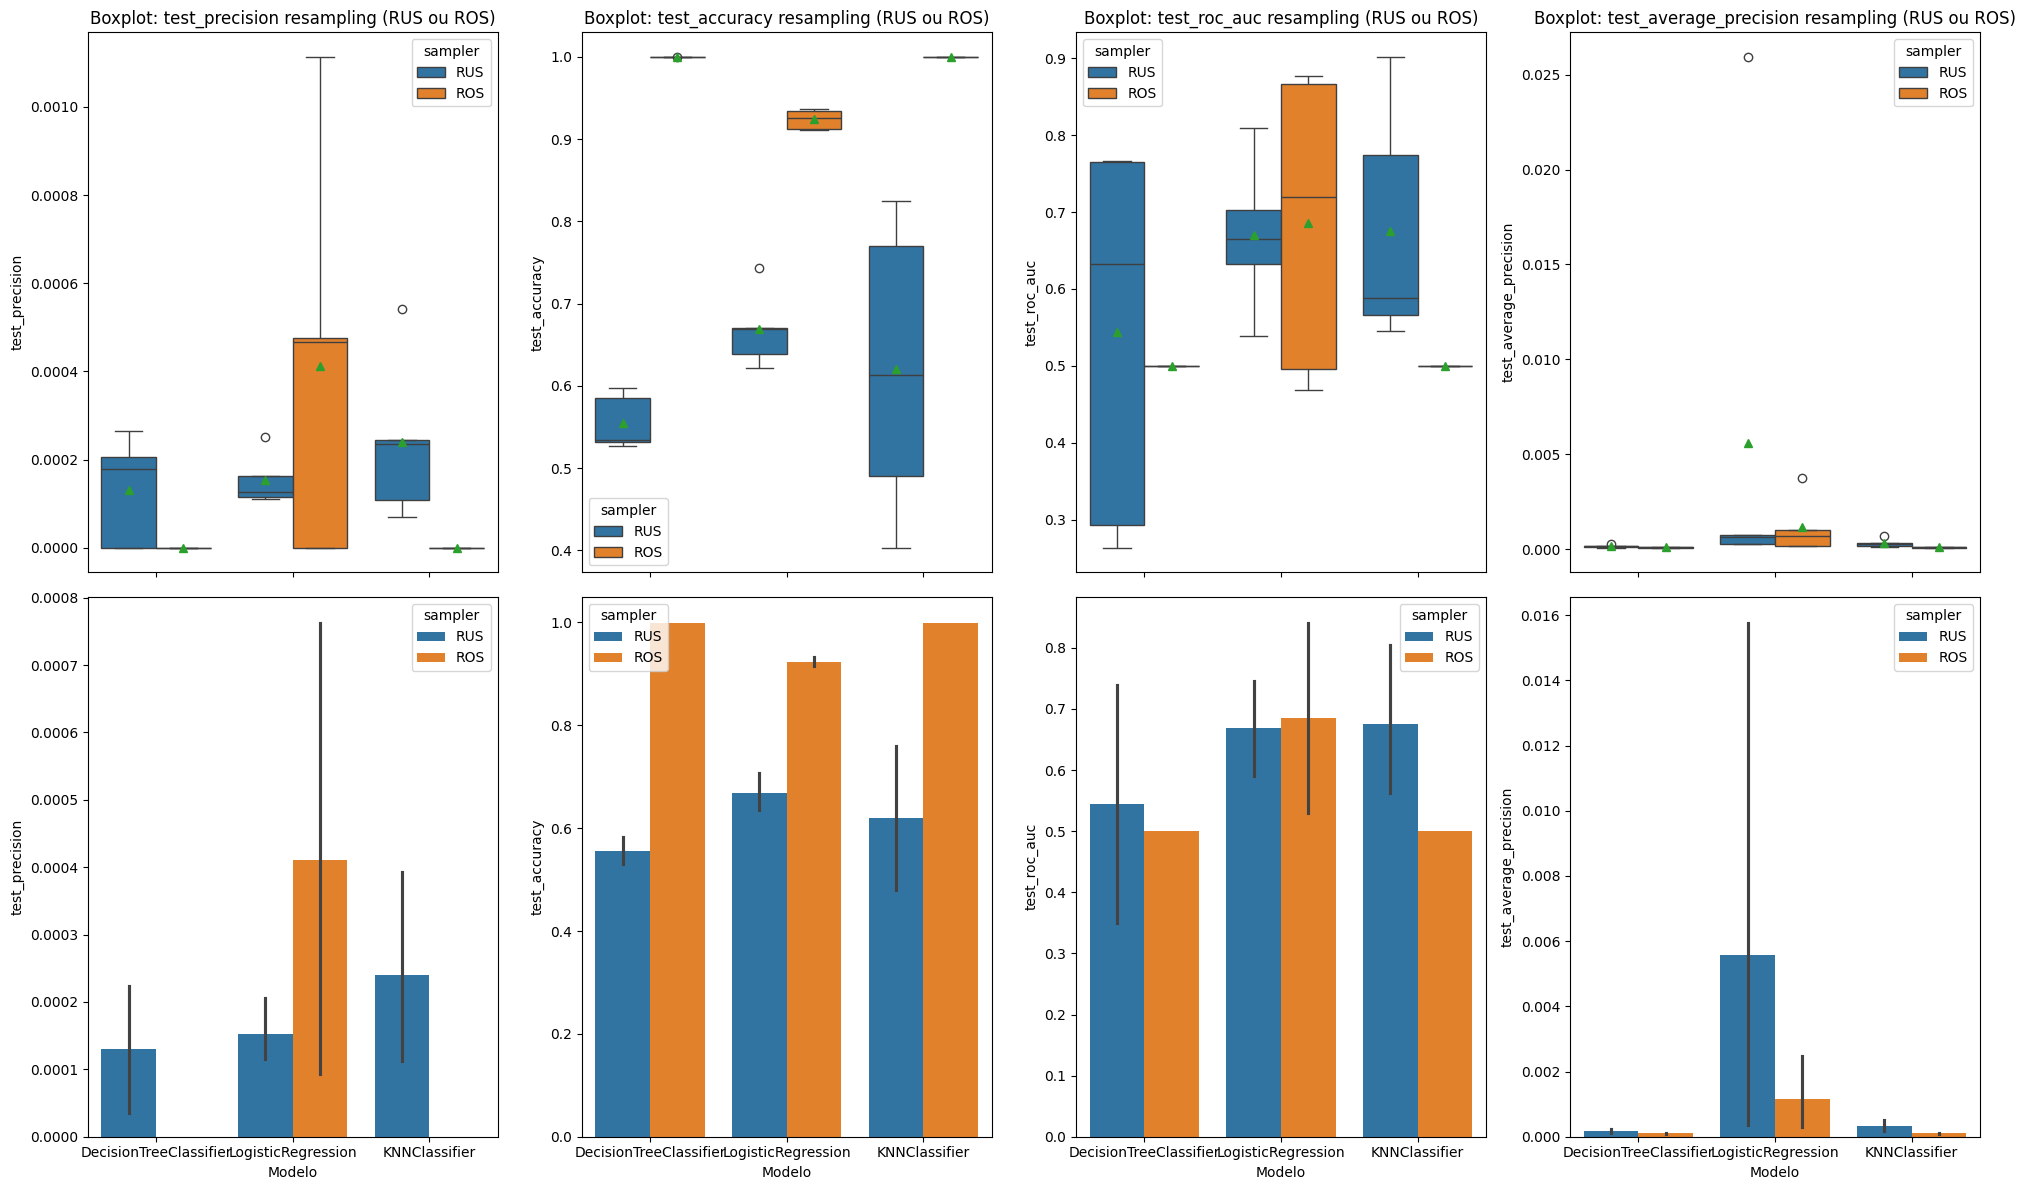

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

columns_scoring = [
    'test_precision', 'test_accuracy', 'test_roc_auc', 'test_average_precision'
]

fig, axes = plt.subplots(2, len(columns_scoring), figsize=(5 * len(columns_scoring), 12),sharex=True)

for idx, metric in enumerate(columns_scoring):
    
    sns.boxplot(
        x="modelo",
        y=metric,
        hue="sampler",
        data=df_results_explode,
        ax=axes[0, idx],
        showmeans=True,
    )
    axes[0, idx].set_title(f"Boxplot: {metric} resampling (RUS ou ROS)")
    axes[0, idx].set_xlabel("Modelo")
    axes[0, idx].set_ylabel(metric)

    
    sns.barplot(
        x="modelo",
        y=metric,
        hue="sampler",
        data=df_results_explode,
        ax=axes[1, idx],
    )
    axes[1, idx].set_xlabel("Modelo")
    axes[1, idx].set_ylabel(metric)
    
plt.tight_layout()
plt.show()


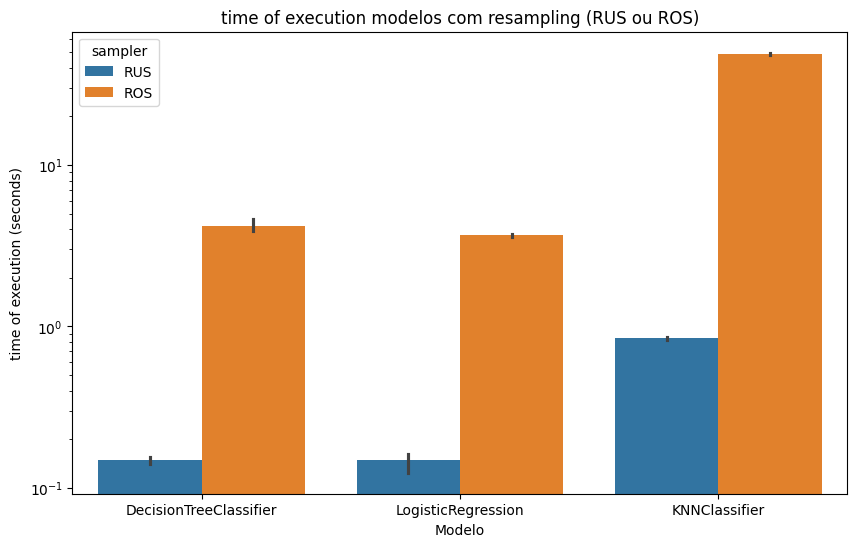

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(
    x="modelo",
    y="time",
    hue="sampler",
    data=df_results_explode,
    ax=ax,
)

ax.set_title("time of execution modelos com resampling (RUS ou ROS)")
ax.set_xlabel("Modelo")
ax.set_ylabel("time of execution (seconds)")
ax.set_yscale('log')
plt.show()

In [38]:
rus =samplers['RUS']
X_res ,y_res = rus.fit_resample(X_train,y_train)


clfRU = LogisticRegression(random_state=42)
clfRU = clfRU.fit(X_res,y_res)

y_predRU = clfRU.predict(X_test)

confusion_matrix(y_test,y_predRU)

array([[26967, 12811],
       [    1,     3]], dtype=int64)

In [39]:

ros =samplers['ROS']
X_res ,y_res = ros.fit_resample(X_train,y_train)


clfRO = LogisticRegression(random_state=42)
clfRO = clfRO.fit(X_res,y_res)

y_predRO = clfRO.predict(X_test)

confusion_matrix(y_test,y_predRO)

C:\Users\vinic\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([[36384,  3394],
       [    1,     3]], dtype=int64)

In [44]:
accuracy_score(y_test,y_predRU) #Random Under Sampler

0.677944799155397

In [45]:
accuracy_score(y_test,y_predRO) #Random Over Sampler 

0.9146598964355739

In [46]:
from sklearn.metrics import f1_score  # Random Under Sampler
f1_score(y_test, y_predRU)

0.00046809174598221254

In [47]:
from sklearn.metrics import f1_score  # Random Under Sampler
f1_score(y_test, y_predRO)

0.0017641870038224052

# conlcusion

# Removing the outliers had a terrible impact on the model because it ended up classifying more than 99% of the data as fraud! This leads me to conclude that removing the outliers caused a loss of information for the model and also led to its instability.